<a href="https://colab.research.google.com/github/annisazhaaf/Final-Project-Model-Klasifikasi-CNN/blob/main/Main%20Model/Training%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SET UP AWAL PROGRAM MODEL**

IMPORT PUSTAKA & FUNGSI YANG DIGUNAKAN

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

MOUNTING AKSES DATA PADA DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CHECKING & COUNT DATA LATIH PADA DRIVE

In [ ]:
train_dir = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/Latih'
class_folders = ['Apicalis', 'Biroi', 'Itama', 'Thoracica']
total_files_found = 0

for folder in class_folders:
    path = os.path.join(train_dir, folder)
    try:
        # Menghitung semua item di dalam folder
        files = os.listdir(path)
        file_count = len(files)
        total_files_found += file_count

        print(f"\nFolder: '{folder}'")
        print(f"Jumlah total item ditemukan: {file_count}")

        # Mencari dan menampilkan file yang BUKAN gambar .jpg atau .png
        non_image_files = [f for f in files if not f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if non_image_files:
            print(f"PERINGATAN! Ditemukan file yang bukan gambar: {non_image_files}")

    except FileNotFoundError:
        print(f"\nFolder: '{folder}' -> TIDAK DITEMUKAN. Periksa kembali nama folder.")

print(f"\n--- Total Keseluruhan Item Terverifikasi: {total_files_found} ---")


Folder: 'Apicalis'
Jumlah total item ditemukan: 160

Folder: 'Biroi'
Jumlah total item ditemukan: 160

Folder: 'Itama'
Jumlah total item ditemukan: 160

Folder: 'Thoracica'
Jumlah total item ditemukan: 160

--- Total Keseluruhan Item Terverifikasi: 640 ---


IMPORT DATA DARI DRIVE & LABELING

In [ ]:
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')
test_dir = os.path.join(main_path, 'Uji')

target_size = (224, 224)
batch_size = 16

print("Memuat data latih...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=target_size,
    batch_size=batch_size,
    shuffle=True
)
print("\nMemuat data validasi...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    label_mode='categorical',
    image_size=target_size,
    batch_size=batch_size,
    shuffle=False
)
print("\nMemuat data uji...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_dataset.class_names
print(f"\nKelas yang ditemukan (sesuai urutan pelabelan): {class_names}")

print("\n--- Contoh Verifikasi Label ---")
for images, labels in train_dataset.take(1):
    print("Bentuk (shape) dari batch gambar:", images.shape)
    print("Bentuk (shape) dari batch label:", labels.shape)
    print("\nContoh label pertama dalam batch (dalam format categorical):")
    print(labels[0].numpy())

    first_label_index = tf.argmax(labels[0]).numpy()
    first_label_name = class_names[first_label_index]
    print(f"Label di atas merepresentasikan kelas: '{first_label_name}'")

Memuat data latih...
Found 640 files belonging to 4 classes.

Memuat data validasi...
Found 80 files belonging to 4 classes.

Memuat data uji...
Found 80 files belonging to 4 classes.

Kelas yang ditemukan (sesuai urutan pelabelan): ['Apicalis', 'Biroi', 'Itama', 'Thoracica']

--- Contoh Verifikasi Label ---
Bentuk (shape) dari batch gambar: (16, 224, 224, 3)
Bentuk (shape) dari batch label: (16, 4)

Contoh label pertama dalam batch (dalam format categorical):
[1. 0. 0. 0.]
Label di atas merepresentasikan kelas: 'Apicalis'


SET UP AUGMENTASI & NORMALISASI MODEL

In [ ]:
target_size = (224, 224)
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,                          # Normalisasi piksel ke rentang [0,1] efficientnetb0
    preprocessing_function=preprocess_input, # Normalisasi default pada rentang [-1,1] mobilenetv2
    rotation_range=30,                       # Rotasi gambar hingga 30 derajat
    zoom_range=0.2,                          # Zoom gambar hingga 20%
    shear_range=0.2,                         # Geser gambar hingga 20%
    horizontal_flip=True,                    # Membalik gambar secara horizontal
    vertical_flip=True                       # Membalik gambar secara vertikal
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
print(" SUCCES, Generator untuk data latih berhasil dibuat!")

# **ARSITEKTUR MODEL MOBILENETV2**

In [ ]:
# Menambahkan Random Seed
tf.random.set_seed(42)

# Pengaturan Location Path
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 50
histories_mobilenet = {}

# Menyiapkan Data Generator
print("\n--- Menyiapkan Data Generator ---")
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)

# Membangun Arsitektur Model
print("\n--- Membangun Arsitektur MobileNetV2 ---")
base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False
model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')])
print("Arsitektur MobileNetV2 selesai dibangun.")

# Menyiapkan Callbacks
print("\n--- Menyiapkan Callbacks ---")

save_dir_mobilenet = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size}/'
os.makedirs(save_dir_mobilenet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_mobilenet, "best_model.keras")
filepath_log = os.path.join(save_dir_mobilenet, "training_log.csv")

checkpoint_mobilenet = ModelCheckpoint(
    filepath=filepath_checkpoint,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

csv_logger_mobilenet = CSVLogger(filepath_log)

early_stopping_mobilenet = EarlyStopping(
    monitor='val_accuracy',
    patience=7, mode='max',
    verbose=1,
    restore_best_weights=True)

print("✅ Callbacks telah siap.")


--- Menyiapkan Data Generator ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Membangun Arsitektur MobileNetV2 ---
✅ Arsitektur MobileNetV2 selesai dibangun.

--- Menyiapkan Callbacks ---
✅ Callbacks telah siap.


In [ ]:
# Periksa dan Compile Model Summary
print("\n--- Menglompilasi Model MobileNetV2 ---")
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()


--- Menglompilasi Model MobileNetV2 ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Training Model Fit MobileNetV2
print(f"\n--- Memulai Pelatihan Model MobileNetV2 (Batch Size: {batch_size}, Epochs: {epochs}) ---")

start_time = time.time()
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_mobilenet, csv_logger_mobilenet, early_stopping_mobilenet])

print(f"\n\n Pelatihan MobileNetV2 Selesai!")
histories_mobilenet[f'bs{batch_size}_epochs{epochs}'] = history_mobilenet.history


--- Memulai Pelatihan Model MobileNetV2 (Batch Size: 16, Epochs: 50) ---
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.3158 - loss: 1.7353
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 845ms/step - accuracy: 0.3165 - loss: 1.7324 - val_accuracy: 0.6000 - val_loss: 1.1312
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.4955 - loss: 1.1811
Epoch 2: val_accuracy improved from 0.60000 to 0.63750, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 826ms/step - accuracy: 0.4964 - loss: 1.1792 - val_accuracy: 0.6375 - val_loss: 0.9753
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.5870 - loss: 1.0389
Epoch 3: val_accuracy improved from 0.63750 to 0.71250, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16

In [ ]:
# Menghitung Waktu dan Ukuran File
end_time = time.time()
total_time = end_time - start_time
num_actual_epochs = len(history_mobilenet.history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(history_mobilenet.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_mobilenet.history['val_accuracy']) + 1
lowest_val_loss = min(history_mobilenet.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_mobilenet.history['val_loss']) + 1

print("RANGKUMAN PELATIHAN")
print("-" * 40)
print(f"Batch Size             : {batch_size}")
print(f"Optimizer              : Adam (LR: 0.001)")
print("-" * 40)
print(f"Val Accuracy Tertinggi : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah      : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Waktu Pelatihan  : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu per Epoch        : {avg_time_per_epoch:.2f} detik")


# Dapatkan ukuran file model terbaik
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik   : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")

RANGKUMAN PELATIHAN
----------------------------------------
Batch Size             : 16
Optimizer              : Adam (LR: 0.001)
----------------------------------------
Val Accuracy Tertinggi : 0.8875 (di Epoch ke-27)
Val Loss Terendah      : 0.5460 (di Epoch ke-30)
Total Waktu Pelatihan  : 19 menit 38.48 detik
Waktu per Epoch        : 34.66 detik
Ukuran Model Terbaik   : 9.23 MB


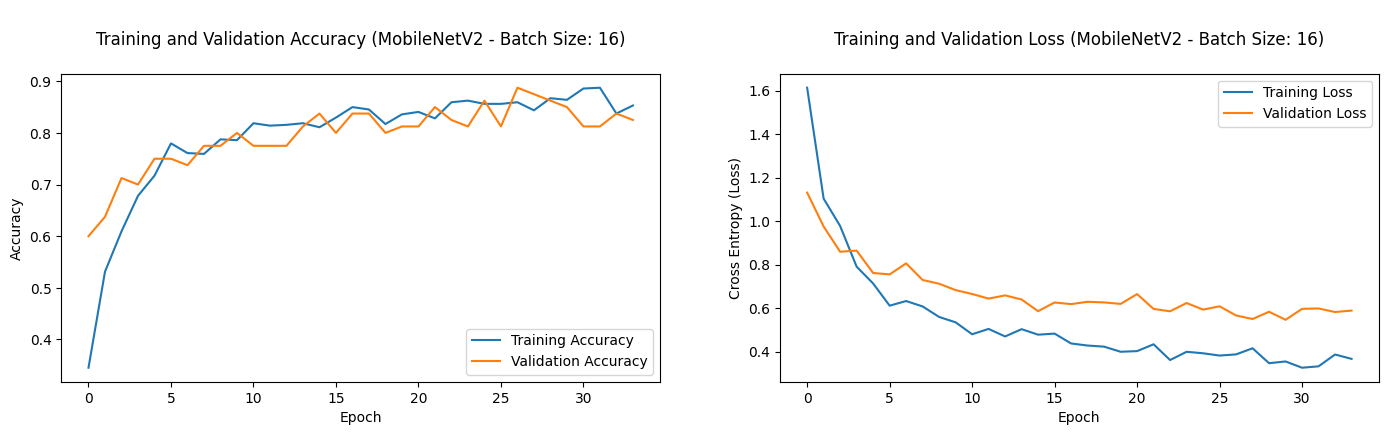

In [ ]:
# Menampilkan Grafik Akurasi dan Loss MobileNetV2
import matplotlib.pyplot as plt
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat dua grafik bersebelahan dalam satu gambar:
    1. Grafik Akurasi (Training vs Validasi)
    2. Grafik Loss (Training vs Validasi)
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Cross Entropy (Loss)')
    plt.xlabel('Epoch')

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

plot_history_side_by_side(history_mobilenet, "MobileNetV2", batch_size)

In [ ]:
# Evaluasi Best Model MobileNetV2
model_path = '/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16/best_model.keras'
test_dir = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/Uji'

target_size = (224, 224)
batch_size = 16

print("Memuat model dari:", model_path)
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat.\n")

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Ditemukan {test_generator.samples} gambar milik {num_classes} kelas.")
print("Kelas:", class_names)
print("\nMelakukan prediksi pada dataset uji...")

steps = int(np.ceil(test_generator.samples / batch_size))

# Lakukan prediksi pada seluruh data uji
predictions = model.predict(test_generator, steps=steps)

# Ambil kelas dengan probabilitas tertinggi sebagai hasil prediksi
y_pred = np.argmax(predictions, axis=1)

print("Prediksi selesai.\n")

Memuat model dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16/best_model.keras
Model berhasil dimuat.

Found 80 images belonging to 4 classes.
Ditemukan 80 gambar milik 4 kelas.
Kelas: ['Apicalis', 'Biroi', 'Itama', 'Thoracica']

Melakukan prediksi pada dataset uji...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Prediksi selesai.



Tabel Confusion Matrix Evaluasi


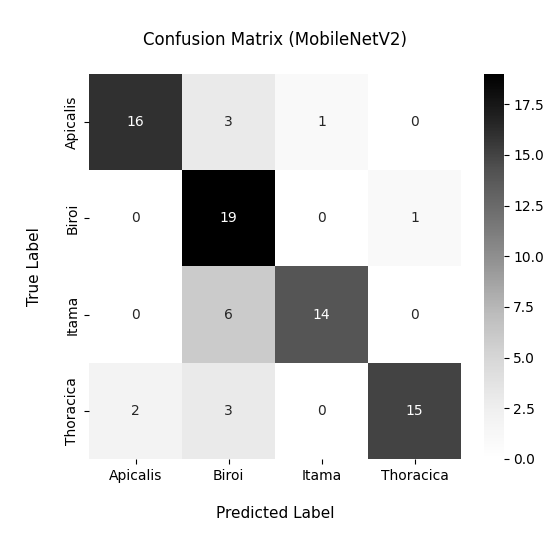

In [ ]:
print("="*70)
print("Tabel Confusion Matrix Evaluasi")
print("="*70)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_names, yticklabels=class_names)
plt.title('\nConfusion Matrix (MobileNetV2)\n', fontsize=12)
plt.ylabel('\nTrue Label\n', fontsize=11)
plt.xlabel('\nPredicted Label\n', fontsize=11)
plt.show()

In [ ]:
print("\n" + "="*60)
print("Tabel Classification Report MobileNetV2")
print("="*60)
# Menggunakan output_dict=True untuk perhitungan manual nanti
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
# Menampilkan report dalam bentuk tabel yang rapi
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string())


Tabel Classification Report MobileNetV2
              precision  recall  f1-score  support
Apicalis       0.888889    0.80  0.842105     20.0
Biroi          0.612903    0.95  0.745098     20.0
Itama          0.933333    0.70  0.800000     20.0
Thoracica      0.937500    0.75  0.833333     20.0
accuracy       0.800000    0.80  0.800000      0.8
macro avg      0.843156    0.80  0.805134     80.0
weighted avg   0.843156    0.80  0.805134     80.0


In [ ]:
print("\n" + "="*60)
print("Perhitungan Akurasi per Kelas dan Total")
print("="*60)
print("Rumus Akurasi: (TP + TN) / (TP + FP + TN + FN)")
print("-" * 60)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    # Total sampel kelas
    total_class_samples = TP + FN

    # Akurasi per kelas (Correct Predictions / Total Samples / Recall / Sensitivity)
    class_accuracy = TP / total_class_samples if total_class_samples > 0 else 0

    print(f"Akurasi Kelas '{class_name}':")
    print(f"  - Biner (Benar/Total) = {TP}/{total_class_samples}")
    print(f"  - Persentase           = {class_accuracy:.2%}\n")

# Perhitungan total akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print("-" * 60)
print(f"Total Akurasi Keseluruhan: {overall_accuracy:.2%}")
print("="*60)


Perhitungan Akurasi per Kelas dan Total
Rumus Akurasi: (TP + TN) / (TP + FP + TN + FN)
------------------------------------------------------------
Akurasi Kelas 'Apicalis':
  - Biner (Benar/Total) = 16/20
  - Persentase           = 80.00%

Akurasi Kelas 'Biroi':
  - Biner (Benar/Total) = 19/20
  - Persentase           = 95.00%

Akurasi Kelas 'Itama':
  - Biner (Benar/Total) = 14/20
  - Persentase           = 70.00%

Akurasi Kelas 'Thoracica':
  - Biner (Benar/Total) = 15/20
  - Persentase           = 75.00%

------------------------------------------------------------
Total Akurasi Keseluruhan: 80.00%


In [ ]:
print("\n" + "="*60)
print("Perhitungan Precision dan Recall per Kelas dan Total")
print("="*60)
print("Rumus Precision : TP / (TP + FP)")
print("Rumus Recall    : TP / (TP + FN)")
print("-" * 60)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Perhitungan untuk Kelas '{class_name}':")
    print(f"  - Precision (Biner) = {precision:.4f}")
    print(f"  - Recall (Biner)    = {recall:.4f}\n")

# Perhitungan total precision dan recall (menggunakan macro average)
total_precision_macro = report['macro avg']['precision']
total_recall_macro = report['macro avg']['recall']

print("-" * 60)
print(f"Total Keseluruhan Precision (Macro Avg): {total_precision_macro:.2%}")
print(f"Total Keseluruhan Recall (Macro Avg):    {total_recall_macro:.2%}")
print("="*60)


Perhitungan Precision dan Recall per Kelas dan Total
Rumus Precision : TP / (TP + FP)
Rumus Recall    : TP / (TP + FN)
------------------------------------------------------------
Perhitungan untuk Kelas 'Apicalis':
  - Precision (Biner) = 0.8889
  - Recall (Biner)    = 0.8000

Perhitungan untuk Kelas 'Biroi':
  - Precision (Biner) = 0.6129
  - Recall (Biner)    = 0.9500

Perhitungan untuk Kelas 'Itama':
  - Precision (Biner) = 0.9333
  - Recall (Biner)    = 0.7000

Perhitungan untuk Kelas 'Thoracica':
  - Precision (Biner) = 0.9375
  - Recall (Biner)    = 0.7500

------------------------------------------------------------
Total Keseluruhan Precision (Macro Avg): 84.32%
Total Keseluruhan Recall (Macro Avg):    80.00%


In [ ]:
# Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Labeling Asli': y_true,
    'Nama Kategori Asli': nama_kategori_asli,
    'Hasil Prediksi Model': y_pred,
    'Nama Kategori Prediksi': nama_kategori_prediksi
}

# Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# Menampilkan tabel hasil prediksi
print("📊 Tabel Hasil Prediksi vs Label Asli:")
print(results_df.to_string()) # Gunakan .to_string() agar semua baris ditampilkan

📊 Tabel Hasil Prediksi vs Label Asli:
    Labeling Asli Nama Kategori Asli  Hasil Prediksi Model Nama Kategori Prediksi
0               0           Apicalis                     0               Apicalis
1               0           Apicalis                     0               Apicalis
2               0           Apicalis                     0               Apicalis
3               0           Apicalis                     1                  Biroi
4               0           Apicalis                     0               Apicalis
5               0           Apicalis                     0               Apicalis
6               0           Apicalis                     0               Apicalis
7               0           Apicalis                     0               Apicalis
8               0           Apicalis                     0               Apicalis
9               0           Apicalis                     0               Apicalis
10              0           Apicalis                     0  

# **MOBILENETV2 FINE TUNING**

In [ ]:
tf.random.set_seed(42)
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 50

print("\n--- Menyiapkan Data Generator ---")
train_datagen = ImageDataGenerator(
    rotation_range=30, zoom_range=0.2, shear_range=0.2,
    horizontal_flip=True, vertical_flip=True,
    preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)
print("Data Generator telah siap.")

print("\n--- Membangun Arsitektur MobileNetV2 untuk Fine-Tuning ---")
base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = True

fine_tune_at = 100
for layer in base_model_mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')])

optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_mobilenet.compile(optimizer=optimizer_fine_tune,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
print("Model siap untuk Fine-Tuning.")
model_mobilenet.summary()

save_dir_mobilenet = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/'
os.makedirs(save_dir_mobilenet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_mobilenet, "best_model_finetuned.keras")
filepath_log = os.path.join(save_dir_mobilenet, "training_log_finetuned.csv")

checkpoint_mobilenet = ModelCheckpoint(filepath=filepath_checkpoint, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
csv_logger_mobilenet = CSVLogger(filename=filepath_log)
early_stopping_mobilenet = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True) # Patience bisa sedikit ditambah untuk fine-tuning
print("Callbacks baru telah siap.")

print("\n--- Memulai Proses Fine-Tuning ---")
history_mobilenet_finetune = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_mobilenet, csv_logger_mobilenet, early_stopping_mobilenet])
print("Pelatihan Fine-Tuning selesai.")


--- Menyiapkan Data Generator ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Data Generator telah siap.

--- Membangun Arsitektur MobileNetV2 untuk Fine-Tuning ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model siap untuk Fine-Tuning.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,866,564 (7.12 MB)

 Non-trainable params: 396,544 (1.51 MB)

Callbacks baru telah siap.

--- Memulai Proses Fine-Tuning ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2489 - loss: 1.9115
Epoch 1: val_accuracy improved from -inf to 0.36250, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.2491 - loss: 1.9104 - val_accuracy: 0.3625 - val_loss: 1.5635
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3101 - loss: 1.6987
Epoch 2: val_accuracy improved from 0.36250 to 0.38750, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.3109 - loss: 1.6958 - val_accuracy: 0.3875 - val_loss: 1.4567
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3745 - loss: 1.3736
Epoch 3: val_accuracy improved from 0.38750 to 0.42500, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.kera

In [ ]:
# Menghitung Waktu dan Metrik Utama
end_time = time.time()
num_actual_epochs = len(history_mobilenet_finetune.history['loss'])

# Mengambil metrik terbaik dari objek history fine-tuning
best_val_acc = max(history_mobilenet_finetune.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_mobilenet_finetune.history['val_accuracy']) + 1
lowest_val_loss = min(history_mobilenet_finetune.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_mobilenet_finetune.history['val_loss']) + 1

# Mendapatkan learning rate dari optimizer yang digunakan
lr_value = optimizer_fine_tune.learning_rate.numpy()

print("\n" + "="*45)
print(" RANGKUMAN PELATIHAN FINE-TUNING ".center(45, "="))
print("="*45)
print(f"Batch Size             : {batch_size}")
print(f"Optimizer              : Adam (LR: {lr_value:.1e})") # Menampilkan LR fine-tuning
print("-" * 45)
print(f"Val Accuracy Tertinggi : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah      : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")

# Dapatkan ukuran file model terbaik dari path checkpoint fine-tuning
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik   : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")
print("="*45)


====== RANGKUMAN PELATIHAN FINE-TUNING ======
Batch Size             : 16
Optimizer              : Adam (LR: 1.0e-05)
---------------------------------------------
Val Accuracy Tertinggi : 0.8500 (di Epoch ke-32)
Val Loss Terendah      : 0.4643 (di Epoch ke-42)
Ukuran Model Terbaik   : 23.47 MB


--- Menampilkan Grafik Hasil Pelatihan (Tampilan Bersih) ---


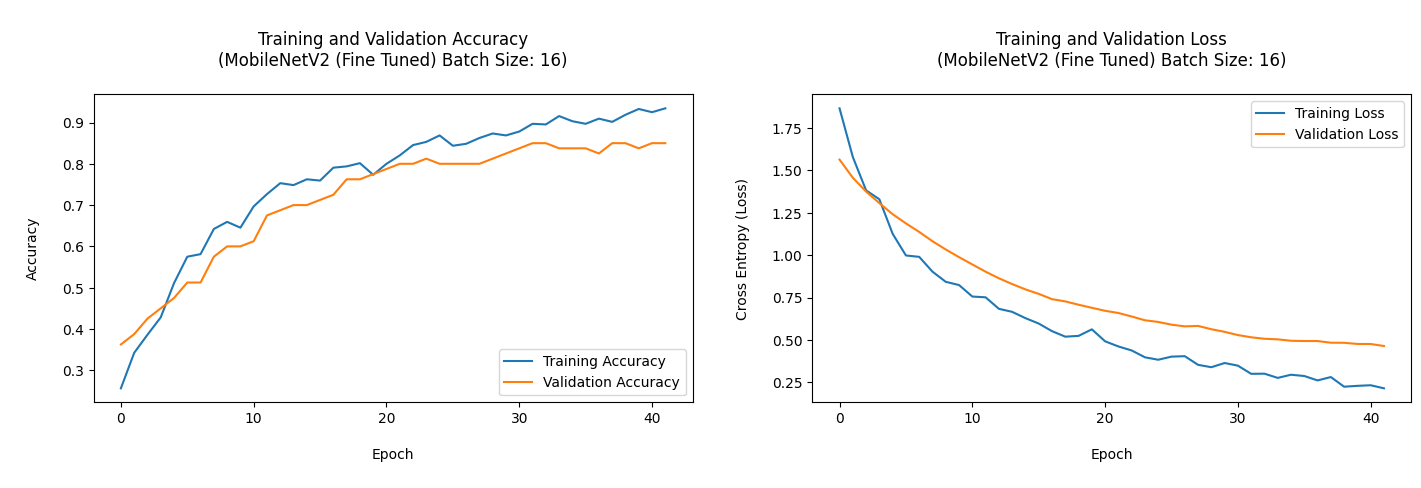

In [ ]:
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat grafik akurasi dan loss tanpa titik poin dan grid.
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # --- Grafik Akurasi (Diperbaiki) ---
    plt.subplot(1, 2, 1)
    # Menghilangkan 'o-' untuk menghapus titik poin
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy\n({model_name} (Fine Tuned) Batch Size: {bs})\n')
    plt.ylabel('\nAccuracy\n')
    plt.xlabel('\nEpoch\n')
    # Menghapus plt.grid(True)

    # --- Grafik Loss (Diperbaiki) ---
    plt.subplot(1, 2, 2)
    # Menghilangkan 'o-' untuk menghapus titik poin
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss\n({model_name} (Fine Tuned) Batch Size: {bs})\n')
    plt.ylabel('\nCross Entropy (Loss)\n')
    plt.xlabel('\nEpoch\n')
    # Menghapus plt.grid(True)

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

# --- Contoh Pemanggilan Fungsi ---
# Pastikan variabel history_mobilenet_finetune dan batch_size sudah ada
print("--- Menampilkan Grafik Hasil Pelatihan (Tampilan Bersih) ---")
plot_history_side_by_side(history_mobilenet_finetune, "MobileNetV2", batch_size)


--- Memuat Model Terbaik Hasil Fine-Tuning ---
Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 80 images belonging to 4 classes.

--- Mengevaluasi Model pada Data Uji ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.9120 - loss: 0.2462

  HASIL EVALUASI PADA DATA UJI  
Test Loss    : 0.2752
Test Accuracy: 0.9000 (90.00%)


--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 791ms/step

Laporan Klasifikasi:

              precision    recall  f1-score   support

    Apicalis       0.78      0.90      0.84        20
       Biroi       0.86      0.95      0.90        20
       Itama       1.00      0.90      0.95        20
   Thoracica       1.00      0.85      0.92        20

    accuracy                           0.90        80
   macro avg       0.91      0.90      0.90        80
weighted avg       0.91      0.90      0.90        80


Confusion Matrix:



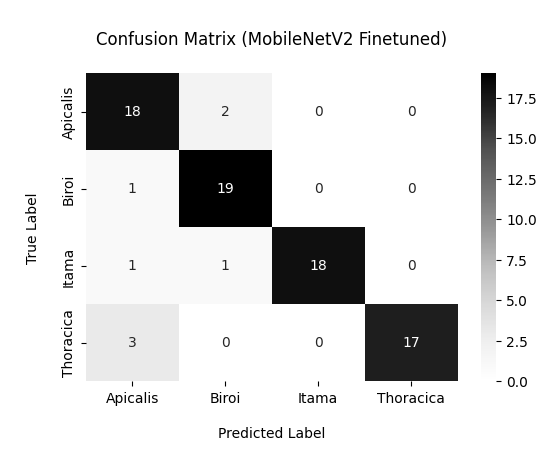

In [ ]:
# -----------------------------------------------------------------------------
# BAGIAN 2: MEMUAT MODEL TERBAIK & MENYIAPKAN DATA UJI
# -----------------------------------------------------------------------------
print("\n--- Memuat Model Terbaik Hasil Fine-Tuning ---")

batch_size = 16
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'

try:
    # Memuat model dari path yang baru
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise


print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Uji')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


# -----------------------------------------------------------------------------
# BAGIAN 3: EVALUASI KUANTITATIF (LOSS & ACCURACY) - (Tidak ada perubahan)
# -----------------------------------------------------------------------------
print("\n--- Mengevaluasi Model pada Data Uji ---")
results = best_model.evaluate(test_generator)

print("\n" + "="*30)
print("  HASIL EVALUASI PADA DATA UJI  ")
print("="*30)
print(f"Test Loss    : {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*30 + "\n")


# -----------------------------------------------------------------------------
# BAGIAN 4: ANALISIS KUALITATIF - (Tidak ada perubahan)
# -----------------------------------------------------------------------------
print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('\nConfusion Matrix (MobileNetV2 Finetuned)\n')
plt.ylabel('\nTrue Label\n')
plt.xlabel('\nPredicted Label\n')
plt.show()

In [ ]:
# Dapatkan nama-nama kelas dari generator uji yang sudah ada
class_names = list(test_generator.class_indices.keys()) # <<< Tambahkan baris ini

# ====================================================================
# BAGIAN 1: TABEL CLASSIFICATION REPORT
# ====================================================================
print("\n" + "="*60)
print("      Tabel Classification Report MobileNetV2 (Fine-Tuned)      ")
print("="*60)

# Menggunakan output_dict=True untuk perhitungan dan tampilan DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Menampilkan report dalam bentuk tabel yang rapi
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string())


# ====================================================================
# BAGIAN 2: PERHITUNGAN RINCI AKURASI
# ====================================================================
print("\n" + "="*60)
print("        Perhitungan Akurasi per Kelas dan Total Akurasi         ")
print("="*60)
print("Rumus Akurasi per Kelas (Recall): TP / (TP + FN)")
print("-" * 60)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP

    # Total sampel aktual untuk kelas ini
    total_class_samples = TP + FN

    # Akurasi per kelas (sebenarnya ini adalah Recall atau Sensitivity)
    class_accuracy = TP / total_class_samples if total_class_samples > 0 else 0

    print(f"Akurasi untuk Kelas '{class_name}':")
    print(f"  - Prediksi Benar / Total Sampel Asli = {TP}/{total_class_samples}")
    print(f"  - Persentase (Recall)                = {class_accuracy:.2%}\n")

# Perhitungan total akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print("-" * 60)
print(f"Total Akurasi Keseluruhan (Overall Accuracy): {overall_accuracy:.2%}")
print("="*60)

# Menghitung Precision dan Recall
print("\n" + "="*60)
print("       Perhitungan Precision dan Recall per Kelas dan Total       ")
print("="*60)
print("Rumus Precision : TP / (TP + FP)")
print("Rumus Recall    : TP / (TP + FN)")
print("-" * 60)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Perhitungan untuk Kelas '{class_name}':")
    print(f"  - Precision = {precision:.4f}")
    print(f"  - Recall    = {recall:.4f}\n")

# Perhitungan total precision dan recall (menggunakan macro average)
total_precision_macro = report['macro avg']['precision']
total_recall_macro = report['macro avg']['recall']

print("-" * 60)
print(f"Total Keseluruhan Precision (Macro Avg): {total_precision_macro:.2%}")
print(f"Total Keseluruhan Recall (Macro Avg):    {total_recall_macro:.2%}")
print("="*60)

# Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Label Asli': y_true,
    'Kategori Asli': nama_kategori_asli,
    'Prediksi Model': y_pred,
    'Kategori Prediksi': nama_kategori_prediksi
}

# Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# Menampilkan tabel hasil prediksi
print("\n📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:")
# Gunakan .to_string() agar semua baris ditampilkan jika data ujinya banyak
print(results_df.to_string())


      Tabel Classification Report MobileNetV2 (Fine-Tuned)      
              precision  recall  f1-score  support
Apicalis       0.782609    0.90  0.837209     20.0
Biroi          0.863636    0.95  0.904762     20.0
Itama          1.000000    0.90  0.947368     20.0
Thoracica      1.000000    0.85  0.918919     20.0
accuracy       0.900000    0.90  0.900000      0.9
macro avg      0.911561    0.90  0.902065     80.0
weighted avg   0.911561    0.90  0.902065     80.0

        Perhitungan Akurasi per Kelas dan Total Akurasi         
Rumus Akurasi per Kelas (Recall): TP / (TP + FN)
------------------------------------------------------------
Akurasi untuk Kelas 'Apicalis':
  - Prediksi Benar / Total Sampel Asli = 18/20
  - Persentase (Recall)                = 90.00%

Akurasi untuk Kelas 'Biroi':
  - Prediksi Benar / Total Sampel Asli = 19/20
  - Persentase (Recall)                = 95.00%

Akurasi untuk Kelas 'Itama':
  - Prediksi Benar / Total Sampel Asli = 18/20
  - Persentase (Recal

# **ARSITEKTUR MODEL EFFICIENTNETB0**

In [ ]:
# Menambahkan Random Seed
tf.random.set_seed(42)

# Pengaturan Location Path
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

# Konfigurasi Awal
target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 50

# Menyiapkan Data Generator
print("\n--- Menyiapkan Data Generator ---")
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# Membangun Arsitektur Model (DENGAN LAPISAN RESCALING)
print("\n--- Membangun Arsitektur EfficientNetB0 ---")
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=input_shape), #layer rescale
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')
])
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_efficientnet.summary()

print(" Model telah dibangun.")

# Menyiapkan Callbacks
print("\n--- Menyiapkan Callbacks ---")

save_dir_effnet = f'/content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0/bs_{batch_size}/'
os.makedirs(save_dir_effnet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_effnet, "best_model.keras")
filepath_log = os.path.join(save_dir_effnet, "training_log.csv")

checkpoint_efficientnet = ModelCheckpoint(
    filepath=filepath_checkpoint,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

csv_logger_efficientnet = CSVLogger(filepath_log)

early_stopping_efficientnet = EarlyStopping(
    monitor='val_accuracy',
    patience=7, mode='max',
    verbose=1,
    restore_best_weights=True)

print("✅ Callbacks siap.")


--- Menyiapkan Data Generator ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Membangun Arsitektur EfficientNetB0 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Model telah dibangun.

--- Menyiapkan Callbacks ---
✅ Callbacks siap.


In [ ]:
# Training Model EfficientNetB0
print(f"\n--- Memulai Pelatihan Model EfficientNetB0 (Batch Size: {batch_size}, Epochs: {epochs}) ---")
histories_efficientnet = {}
start_time = time.time()
history_efficientnet = model_efficientnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
   callbacks=[checkpoint_efficientnet, csv_logger_efficientnet, early_stopping_efficientnet])

print(f"\n\n Pelatihan EfficientNetB0 Selesai!")
histories_efficientnet[f'bs{batch_size}_epochs{epochs}'] = history_efficientnet.history


--- Memulai Pelatihan Model EfficientNetB0 (Batch Size: 16, Epochs: 50) ---
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.2238 - loss: 1.4191
Epoch 1: val_accuracy did not improve from 0.25000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.2238 - loss: 1.4194 - val_accuracy: 0.2500 - val_loss: 1.4061
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2437 - loss: 1.4364
Epoch 2: val_accuracy did not improve from 0.25000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.2432 - loss: 1.4365 - val_accuracy: 0.2500 - val_loss: 1.3951
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.2256 - loss: 1.4156
Epoch 3: val_accuracy did not improve from 0.25000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.2259 - loss: 1.4154 - val_accuracy: 0.2500 - val_loss: 1.4386
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.2509 - loss: 1.4449
Epoch 4: val_accuracy did not improve from 0.25000
40/40 ━━━━━━━━━━━━━━━━

In [ ]:
# Menghitung Waktu dan Ukuran File
end_time = time.time()
total_time = end_time - start_time
num_actual_epochs = len(history_efficientnet.history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(history_efficientnet.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_efficientnet.history['val_accuracy']) + 1
lowest_val_loss = min(history_efficientnet.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_efficientnet.history['val_loss']) + 1

print("RANGKUMAN PELATIHAN")
print("-" * 40)
print(f"Batch Size             : {batch_size}")
print(f"Optimizer              : Adam (LR: 0.001)")
print("-" * 40)
print(f"Val Accuracy Tertinggi : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah      : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Waktu Pelatihan  : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu per Epoch        : {avg_time_per_epoch:.2f} detik")


# Dapatkan ukuran file model terbaik
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik   : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")

RANGKUMAN PELATIHAN
----------------------------------------
Batch Size             : 16
Optimizer              : Adam (LR: 0.001)
----------------------------------------
Val Accuracy Tertinggi : 0.2500 (di Epoch ke-1)
Val Loss Terendah      : 1.3900 (di Epoch ke-6)
Total Waktu Pelatihan  : 2 menit 29.72 detik
Waktu per Epoch        : 18.72 detik
Ukuran Model Terbaik   : 16.31 MB


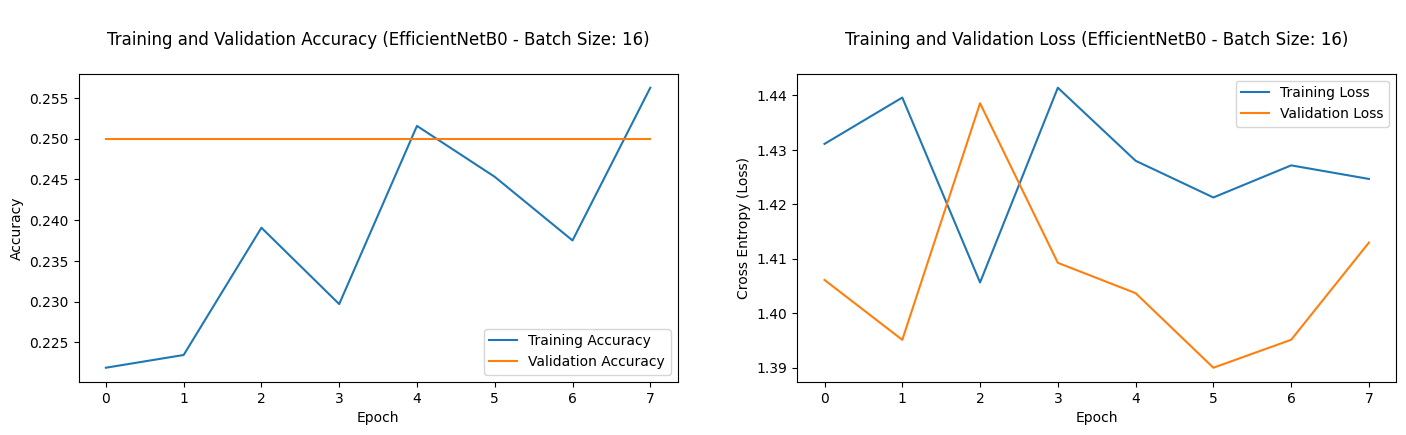

In [ ]:
# Menampilkan Grafik Akurasi dan Loss EfficientNetB0
import matplotlib.pyplot as plt
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat dua grafik bersebelahan dalam satu gambar:
    1. Grafik Akurasi (Training vs Validasi)
    2. Grafik Loss (Training vs Validasi)
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Cross Entropy (Loss)')
    plt.xlabel('Epoch')

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

plot_history_side_by_side(history_efficientnet, "EfficientNetB0", batch_size)

EVALUASI MODEL EFFICIENTNETB0

In [ ]:
# Evaluasi Best Model MobileNetV2
model_path = '/content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0/bs_16/best_model.keras'
test_dir = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/Uji'

target_size = (224, 224)
batch_size = 16

print("Memuat model dari:", model_path)
model = tf.keras.models.load_model(model_path)
print("Model berhasil dimuat.\n")

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

print(f"Ditemukan {test_generator.samples} gambar milik {num_classes} kelas.")
print("Kelas:", class_names)
print("\nMelakukan prediksi pada dataset uji...")

steps = int(np.ceil(test_generator.samples / batch_size))

# Lakukan prediksi pada seluruh data uji
predictions = model.predict(test_generator, steps=steps)

# Ambil kelas dengan probabilitas tertinggi sebagai hasil prediksi
y_pred = np.argmax(predictions, axis=1)

print("Prediksi selesai.\n")

Memuat model dari: /content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0/bs_16/best_model.keras
Model berhasil dimuat.

Found 80 images belonging to 4 classes.
Ditemukan 80 gambar milik 4 kelas.
Kelas: ['Apicalis', 'Biroi', 'Itama', 'Thoracica']

Melakukan prediksi pada dataset uji...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step
Prediksi selesai.



Tabel Confusion Matrix Evaluasi


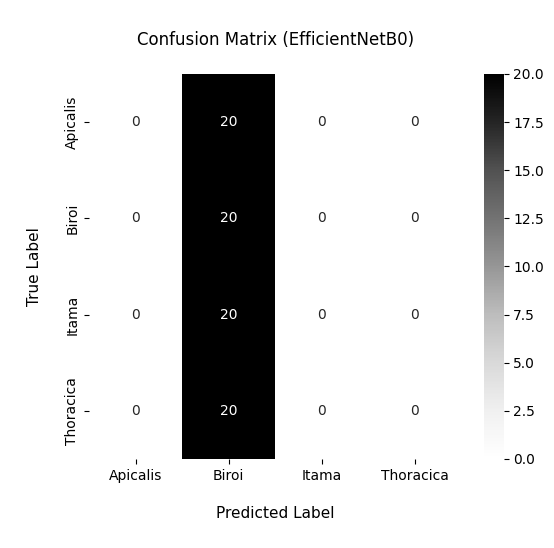

In [ ]:
print("="*70)
print("Tabel Confusion Matrix Evaluasi")
print("="*70)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_names, yticklabels=class_names)
plt.title('\nConfusion Matrix (EfficientNetB0)\n', fontsize=12)
plt.ylabel('\nTrue Label\n', fontsize=11)
plt.xlabel('\nPredicted Label\n', fontsize=11)
plt.show()

--- Menampilkan Sampel dari: Sampel Data Latih ---


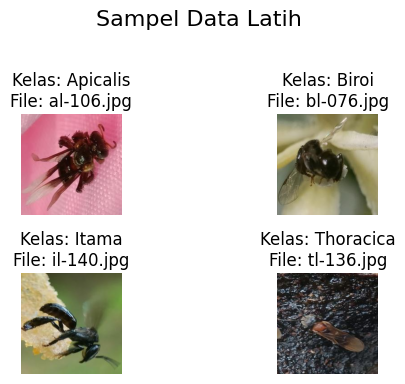

--- Menampilkan Sampel dari: Sampel Data Validasi ---


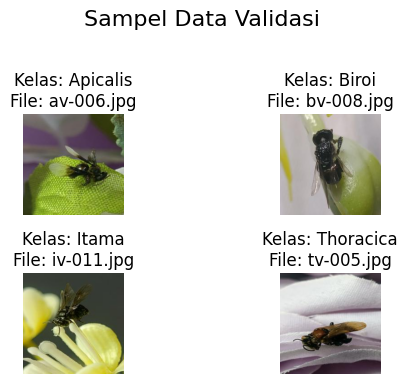

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- Konfigurasi Path (Sesuaikan jika perlu) ---
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

# Fungsi untuk menampilkan gambar sampel
def visualize_data(data_dir, title):
    print(f"--- Menampilkan Sampel dari: {title} ---")

    # Dapatkan daftar nama kelas (nama sub-folder)
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    if not class_names:
        print(f"ERROR: Tidak ada sub-folder kelas yang ditemukan di dalam {data_dir}")
        return

    plt.figure(figsize=(6, 4))

    # Ambil 1 gambar acak dari setiap kelas
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        try:
            image_files = os.listdir(class_path)
            if not image_files:
                print(f"WARNING: Tidak ada gambar di folder {class_path}")
                continue

            random_image_file = random.choice(image_files)
            image_path = os.path.join(class_path, random_image_file)

            # Buka gambar dan tampilkan
            ax = plt.subplot(2, 2, i + 1) # Asumsi ada 4 kelas
            img = Image.open(image_path)
            plt.imshow(img)
            plt.title(f"Kelas: {class_name}\nFile: {random_image_file}")
            plt.axis("off")

        except Exception as e:
            print(f"ERROR saat memproses kelas {class_name}: {e}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Jalankan visualisasi untuk data latih dan validasi
visualize_data(train_dir, "Sampel Data Latih")
visualize_data(validation_dir, "Sampel Data Validasi")

# **EFFICIENTNETB0 FINE TUNING**

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# --- Konfigurasi (Sama seperti sebelumnya) ---
tf.random.set_seed(42)
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')
target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 100

# --- STRATEGI 1: AUGMENTASI DATA LEBIH AGRESIF ---
print("\n--- Menyiapkan Data Generator dengan Augmentasi Agresif ---")
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)

# --- TAHAP 1: FEATURE EXTRACTION (LR RENDAH) ---
print("\n--- Memulai Tahap 1: Feature Extraction ---")
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False
model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')
])
model_efficientnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
save_dir = f'/content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/bs_{batch_size}/'
os.makedirs(save_dir, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir, "best_model.keras")
checkpoint = ModelCheckpoint(filepath=filepath_checkpoint, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
csv_logger = CSVLogger(os.path.join(save_dir, "training_log.csv"), append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True) # Monitor val_loss untuk kestabilan

initial_epochs = 20 # Beri waktu lebih untuk tahap awal
history_initial = model_efficientnet.fit(
    train_generator, epochs=initial_epochs, validation_data=validation_generator,
    callbacks=[checkpoint, csv_logger, early_stopping])

# --- TAHAP 2: FINE-TUNING LEBIH DALAM ---
print("\n--- Memulai Tahap 2: Fine-Tuning Lebih Dalam ---")
base_model.trainable = True

# STRATEGI 2: Cairkan lebih banyak lapisan. Misal, dari layer 100 ke atas.
# EfficientNetB0 punya sekitar 237 lapisan.

fine_tune_from_layer = 100
for layer in base_model.layers[:fine_tune_from_layer]:
    layer.trainable = False

model_efficientnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 0.00001
    loss='categorical_crossentropy', metrics=['accuracy'])

print(f"Model di-compile ulang. Lapisan dari index {fine_tune_from_layer} ke atas kini dapat dilatih.")

history_fine_tune = model_efficientnet.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=validation_generator,
    callbacks=[checkpoint, csv_logger, early_stopping]
)


--- Menyiapkan Data Generator dengan Augmentasi Agresif ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Memulai Tahap 1: Feature Extraction ---
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2191 - loss: 1.4527
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 478ms/step - accuracy: 0.2194 - loss: 1.4523 - val_accuracy: 0.2500 - val_loss: 1.3872
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2209 - loss: 1.4196
Epoch 2: val_accuracy did not improve from 0.25000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.2216 - loss: 1.4194 - val_accuracy: 0.2500 - val_loss: 1.3864
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.2235 - loss: 1.4209
Epoch 3: val_accuracy did not improve from 0.25000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0

In [ ]:
full_history = {}
for key in history_initial.history.keys():
    full_history[key] = history_initial.history[key] + history_fine_tune.history[key]

# --- Kalkulasi Metrik dari History Gabungan ---
total_time = end_time - start_time
num_actual_epochs = len(full_history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(full_history['val_accuracy'])
epoch_best_val_acc = np.argmax(full_history['val_accuracy']) + 1
lowest_val_loss = min(full_history['val_loss'])
epoch_lowest_val_loss = np.argmin(full_history['val_loss']) + 1

# --- Tampilkan Rangkuman ---
print("\n" + "="*50)
print("RANGKUMAN PELATIHAN KESELURUHAN (FINE-TUNING)")
print("="*50)
print(f"Batch Size             : {batch_size}")
# Memberikan info LR yang lebih detail untuk kedua tahap
print(f"Optimizer              : Adam (Tahap 1 LR: 1e-4, Tahap 2 LR: 1e-5)")
print("-" * 50)
print(f"Val Accuracy Tertinggi : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah      : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Epoch Berjalan   : {num_actual_epochs} dari {epochs} epochs")
print(f"Total Waktu Pelatihan  : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu Rata-rata/Epoch  : {avg_time_per_epoch:.2f} detik")

# Dapatkan ukuran file model terbaik yang disimpan oleh ModelCheckpoint
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik   : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")
except Exception as e:
    print(f"⚠️ Tidak dapat membaca ukuran file model: {e}")

print("="*50)


RANGKUMAN PELATIHAN KESELURUHAN (FINE-TUNING)
Batch Size             : 16
Optimizer              : Adam (Tahap 1 LR: 1e-4, Tahap 2 LR: 1e-5)
--------------------------------------------------
Val Accuracy Tertinggi : 0.4250 (di Epoch ke-70)
Val Loss Terendah      : 1.2278 (di Epoch ke-63)
Total Epoch Berjalan   : 78 dari 100 epochs
Total Waktu Pelatihan  : 0 menit 0.00 detik
Waktu Rata-rata/Epoch  : 0.00 detik
Ukuran Model Terbaik   : 45.70 MB


Model terbaik dari /content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/bs_16/best_model.keras telah dimuat.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


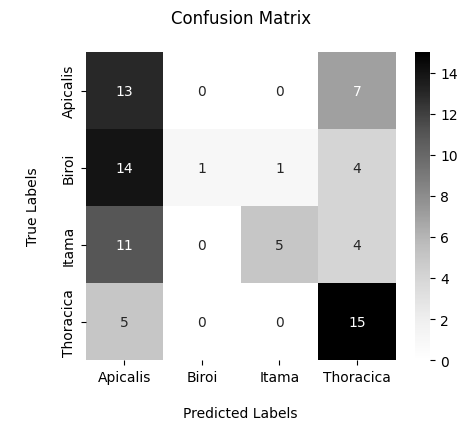


Laporan Klasifikasi:

              precision    recall  f1-score   support

    Apicalis       0.30      0.65      0.41        20
       Biroi       1.00      0.05      0.10        20
       Itama       0.83      0.25      0.38        20
   Thoracica       0.50      0.75      0.60        20

    accuracy                           0.42        80
   macro avg       0.66      0.43      0.37        80
weighted avg       0.66      0.42      0.37        80



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Muat kembali model terbaik yang disimpan oleh checkpoint
best_model_path = filepath_checkpoint
# Pastikan filepath_checkpoint adalah variabel yang benar dari kode training Anda
model_efficientnet.load_weights(best_model_path)
print(f"Model terbaik dari {best_model_path} telah dimuat.")

# Dapatkan prediksi dari validation generator
# Reset generator sebelum melakukan prediksi untuk memastikan urutan data benar
validation_generator.reset()

# Hitung langkah prediksi dan pastikan itu adalah integer
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

predictions = model_efficientnet.predict(validation_generator, steps=steps)
# Dapatkan label kelas dengan probabilitas tertinggi
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan label yang sebenarnya (true labels)
true_classes = validation_generator.classes
# Dapatkan mapping dari nama kelas ke index
class_labels = list(validation_generator.class_indices.keys())

# Buat Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix\n')
plt.ylabel('\nTrue Labels\n')
plt.xlabel('\nPredicted Labels\n')
plt.show()

# Tampilkan Laporan Klasifikasi
# Ini akan memberikan metrik presisi, recall, f1-score per kelas
print("\nLaporan Klasifikasi:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# --- Konfigurasi (Sama seperti sebelumnya) ---
tf.random.set_seed(42)
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')
target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 100

# --- STRATEGI 1: AUGMENTASI DATA LEBIH AGRESIF ---
print("\n--- Menyiapkan Data Generator dengan Augmentasi Agresif ---")
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)
validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)

start_time = time.time()
# --- TAHAP 1: FEATURE EXTRACTION (LR RENDAH) ---
print("\n--- Memulai Tahap 1: Feature Extraction ---")
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False
model_efficientnet = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')
])
model_efficientnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
save_dir = f'/content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/newbs_{batch_size}/'
os.makedirs(save_dir, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir, "best_model.keras")
checkpoint = ModelCheckpoint(filepath=filepath_checkpoint, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
csv_logger = CSVLogger(os.path.join(save_dir, "training_log.csv"), append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True)

initial_epochs = 20 # Beri waktu lebih untuk tahap awal
history_initial = model_efficientnet.fit(
    train_generator, epochs=initial_epochs, validation_data=validation_generator,
    callbacks=[checkpoint, csv_logger, early_stopping])

# --- TAHAP 2: FINE-TUNING LEBIH DALAM ---
print("\n--- Memulai Tahap 2: Fine-Tuning Lebih Dalam ---")
base_model.trainable = True

# STRATEGI 2: Cairkan lebih banyak lapisan. Misal, dari layer 100 ke atas.
# EfficientNetB0 punya sekitar 237 lapisan.

fine_tune_from_layer = 100
for layer in base_model.layers[:fine_tune_from_layer]:
    layer.trainable = False

model_efficientnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 0.00001
    loss='categorical_crossentropy', metrics=['accuracy'])

print(f"Model di-compile ulang. Lapisan dari index {fine_tune_from_layer} ke atas kini dapat dilatih.")

history_fine_tune = model_efficientnet.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=validation_generator,
    callbacks=[checkpoint, csv_logger, early_stopping]
)

end_time = time.time()


--- Menyiapkan Data Generator dengan Augmentasi Agresif ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Memulai Tahap 1: Feature Extraction ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2499 - loss: 1.4491
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to /content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/newbs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.2499 - loss: 1.4490 - val_accuracy: 0.2500 - val_loss: 1.3872
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.2834 - loss: 1.4088
Epoch 2: val_accuracy improved from 0.25000 to 0.30000, saving model to /content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/newbs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 295ms/step - accuracy: 0.2834 - loss: 1.4088 - val_accuracy: 0.3000 - val_loss: 1.3862
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2899 - loss: 1.4062
Epoch 3: val_accuracy did not improve from 0.30000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.2893 - loss: 1.4063 - val_accuracy: 0.2500 - val_loss: 1.3861
Epoch 4/2

In [ ]:
full_history = {}
for key in history_initial.history.keys():
    full_history[key] = history_initial.history[key] + history_fine_tune.history[key]

# --- Kalkulasi Metrik dari History Gabungan ---
total_time = end_time - start_time
num_actual_epochs = len(full_history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(full_history['val_accuracy'])
epoch_best_val_acc = np.argmax(full_history['val_accuracy']) + 1
lowest_val_loss = min(full_history['val_loss'])
epoch_lowest_val_loss = np.argmin(full_history['val_loss']) + 1

# --- Tampilkan Rangkuman ---
print("\n" + "="*50)
print("RANGKUMAN PELATIHAN KESELURUHAN (FINE-TUNING)")
print("="*50)
print(f"Batch Size             : {batch_size}")
# Memberikan info LR yang lebih detail untuk kedua tahap
print(f"Optimizer              : Adam (Tahap 1 LR: 1e-4, Tahap 2 LR: 1e-5)")
print("-" * 50)
print(f"Val Accuracy Tertinggi : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah      : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Epoch Berjalan   : {num_actual_epochs} dari {epochs} epochs")
print(f"Total Waktu Pelatihan  : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu Rata-rata/Epoch  : {avg_time_per_epoch:.2f} detik")

# Dapatkan ukuran file model terbaik yang disimpan oleh ModelCheckpoint
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik   : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")
except Exception as e:
    print(f"⚠️ Tidak dapat membaca ukuran file model: {e}")

print("="*50)


RANGKUMAN PELATIHAN KESELURUHAN (FINE-TUNING)
Batch Size             : 16
Optimizer              : Adam (Tahap 1 LR: 1e-4, Tahap 2 LR: 1e-5)
--------------------------------------------------
Val Accuracy Tertinggi : 0.4875 (di Epoch ke-61)
Val Loss Terendah      : 1.1718 (di Epoch ke-61)
Total Epoch Berjalan   : 76 dari 100 epochs
Total Waktu Pelatihan  : 20 menit 18.52 detik
Waktu Rata-rata/Epoch  : 16.03 detik
Ukuran Model Terbaik   : 45.70 MB


Model terbaik dari /content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/newbs_16/best_model.keras telah dimuat.
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


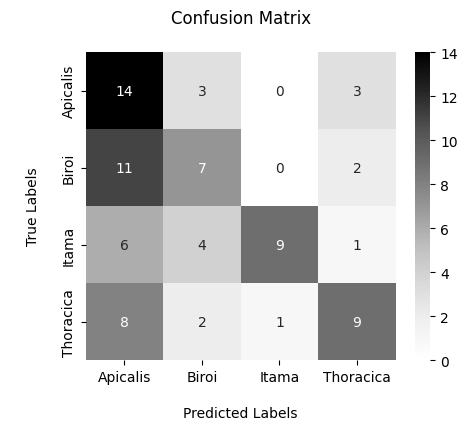


Laporan Klasifikasi (per Kelas dan Rata-rata):

              precision    recall  f1-score   support

    Apicalis       0.36      0.70      0.47        20
       Biroi       0.44      0.35      0.39        20
       Itama       0.90      0.45      0.60        20
   Thoracica       0.60      0.45      0.51        20

    accuracy                           0.49        80
   macro avg       0.57      0.49      0.49        80
weighted avg       0.57      0.49      0.49        80


--- Metrik Performa Keseluruhan (Hasil Akhir) ---
Akurasi Keseluruhan (Overall Accuracy): 0.4875 (atau 48.75%)

--- Detail Hasil Prediksi pada Setiap Gambar ---
    ID Gambar (Filename) Kelas Asli (True Class)  \
0    Apicalis/av-001.jpg                Apicalis   
1    Apicalis/av-002.jpg                Apicalis   
2    Apicalis/av-003.jpg                Apicalis   
3    Apicalis/av-004.jpg                Apicalis   
4    Apicalis/av-005.jpg                Apicalis   
5    Apicalis/av-006.jpg                Ap

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
import pandas as pd

# --- Asumsi kode Anda untuk mendefinisikan model_efficientnet dan validation_generator ada di sini ---
# --- Juga, asumsikan filepath_checkpoint sudah benar ---

# Muat kembali model terbaik yang disimpan oleh checkpoint
# best_model_path = filepath_checkpoint
# Untuk contoh ini, kita gunakan path langsung
best_model_path = '/content/drive/MyDrive/Skripsi/Saved Models/EfficientNetB0_Aggressive/newbs_16/best_model.keras'
print(f"Model terbaik dari {best_model_path} telah dimuat.")
model_to_evaluate = tf.keras.models.load_model(best_model_path)


# Dapatkan prediksi dari validation generator
# Reset generator sebelum melakukan prediksi untuk memastikan urutan data benar
validation_generator.reset()

# Hitung langkah prediksi dan pastikan itu adalah integer
steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

predictions = model_to_evaluate.predict(validation_generator, steps=steps)
# Dapatkan label kelas dengan probabilitas tertinggi
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan label yang sebenarnya (true labels)
true_classes = validation_generator.classes
# Dapatkan mapping dari nama kelas ke index
class_labels = list(validation_generator.class_indices.keys())

# --- Kode Anda untuk menampilkan Confusion Matrix ---
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix\n')
plt.ylabel('\nTrue Labels\n')
plt.xlabel('\nPredicted Labels\n')
plt.show()

# --- Kode Anda untuk menampilkan Laporan Klasifikasi ---
print("\nLaporan Klasifikasi (per Kelas dan Rata-rata):\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


# --- KODE TAMBAHAN: Perhitungan Metrik Keseluruhan ---
print("\n--- Metrik Performa Keseluruhan (Hasil Akhir) ---")

# 1. Akurasi Keseluruhan (Overall Accuracy)
# Cara 1: Menggunakan fungsi dari sklearn
overall_accuracy = accuracy_score(true_classes, predicted_classes)
# Cara 2: Menghitung manual dari confusion matrix
# overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"Akurasi Keseluruhan (Overall Accuracy): {overall_accuracy:.4f} (atau {overall_accuracy:.2%})")

# Catatan: Presisi dan Recall keseluruhan sudah ada di 'Laporan Klasifikasi' di atas
# (lihat baris 'macro avg' dan 'weighted avg')


# --- KODE TAMBAHAN: Tabel Detail Prediksi per Gambar ---
print("\n--- Detail Hasil Prediksi pada Setiap Gambar ---")

# Dapatkan daftar nama file dari generator
filenames = validation_generator.filenames

# Konversi indeks kelas menjadi nama kelas yang bisa dibaca
predicted_class_names = [class_labels[i] for i in predicted_classes]
true_class_names = [class_labels[i] for i in true_classes]

# Buat DataFrame menggunakan Pandas
results_df = pd.DataFrame({
    'ID Gambar (Filename)': filenames,
    'Kelas Asli (True Class)': true_class_names,
    'Kelas Prediksi (Predicted Class)': predicted_class_names
})

results_df['Status'] = np.where(results_df['Kelas Asli (True Class)'] == results_df['Kelas Prediksi (Predicted Class)'], 'Benar', 'SALAH')

# Atur opsi Pandas agar semua baris ditampilkan
pd.set_option('display.max_rows', None)
print(results_df)

In [ ]:
import pandas as pd
import numpy as np

# --- Asumsi variabel-variabel ini sudah ada dari kode sebelumnya ---
# validation_generator, predictions
# ------------------------------------------------------------------


# ====================================================================
# BAGIAN: TABEL PERBANDINGAN PREDIKSI VS LABEL ASLI
# (Kode disesuaikan agar sesuai dengan format yang Anda inginkan)
# ====================================================================

# 1. Definisikan variabel sesuai dengan format baru
y_true = validation_generator.classes
y_pred = np.argmax(predictions, axis=1)
class_names = list(validation_generator.class_indices.keys())

# 2. Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# 3. Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Label Asli': y_true,
    'Kategori Asli': nama_kategori_asli,
    'Prediksi Model': y_pred,
    'Kategori Prediksi': nama_kategori_prediksi
}

# 4. Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# 5. Menampilkan tabel hasil prediksi menggunakan .to_string()
print("\n📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:")
# Gunakan .to_string() agar semua baris ditampilkan jika data ujinya banyak
print(results_df.to_string())


📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:
    Label Asli Kategori Asli  Prediksi Model Kategori Prediksi
0            0      Apicalis               0          Apicalis
1            0      Apicalis               0          Apicalis
2            0      Apicalis               0          Apicalis
3            0      Apicalis               0          Apicalis
4            0      Apicalis               1             Biroi
5            0      Apicalis               1             Biroi
6            0      Apicalis               0          Apicalis
7            0      Apicalis               1             Biroi
8            0      Apicalis               0          Apicalis
9            0      Apicalis               0          Apicalis
10           0      Apicalis               0          Apicalis
11           0      Apicalis               0          Apicalis
12           0      Apicalis               0          Apicalis
13           0      Apicalis               3         Thorac

# **EVALUASI MOBILENETV2 PADA DATA BARU**


--- Memuat Model Terbaik Hasil Fine-Tuning ---
Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 20 images belonging to 4 classes.

--- Mengevaluasi Model pada Data Uji ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.8917 - loss: 0.5484

  HASIL EVALUASI PADA DATA UJI  
Test Loss    : 0.5446
Test Accuracy: 0.9000 (90.00%)


--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step

Laporan Klasifikasi:

               precision    recall  f1-score   support

 Uji Apicalis       0.71      1.00      0.83         5
    Uji Biroi       1.00      0.80      0.89         5
    Uji Itama       1.00      1.00      1.00         5
Uji Thoracica       1.00      0.80      0.89         5

     accuracy                           0.90        20
    macro avg       0.93      0.90      0.90        20
 weighted avg       0.93      0.90      0.90        20


Confusion Matrix:



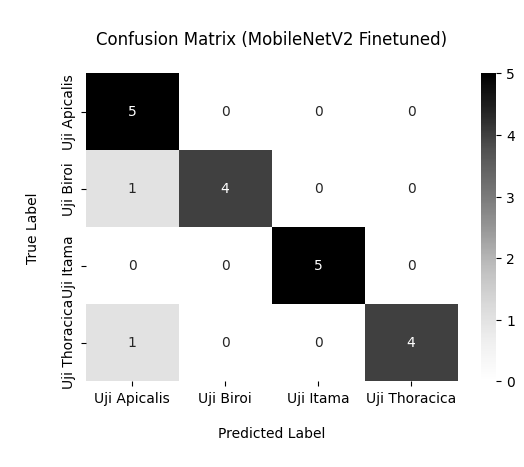

In [ ]:
print("\n--- Memuat Model Terbaik Hasil Fine-Tuning ---")

batch_size = 16
target_size = (224, 224)
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru'
try:
    # Memuat model dari path yang baru
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise

print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Data Uji Google Resized')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print("\n--- Mengevaluasi Model pada Data Uji ---")
results = best_model.evaluate(test_generator)

print("\n" + "="*30)
print("  HASIL EVALUASI PADA DATA UJI  ")
print("="*30)
print(f"Test Loss    : {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*30 + "\n")

print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('\nConfusion Matrix (MobileNetV2 Finetuned)\n')
plt.ylabel('\nTrue Label\n')
plt.xlabel('\nPredicted Label\n')
plt.show()

In [ ]:
# Dapatkan nama-nama kelas dari generator uji yang sudah ada
class_names = list(test_generator.class_indices.keys())

print("\n" + "="*60)
print("      Tabel Classification Report MobileNetV2 (Fine-Tuned)      ")
print("="*60)

# Menggunakan output_dict=True untuk perhitungan dan tampilan DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Menampilkan report dalam bentuk tabel yang rapi
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string())

print("\n" + "="*60)
print("        Perhitungan Akurasi per Kelas dan Total Akurasi         ")
print("="*60)
print("Rumus Akurasi per Kelas (Recall): TP / (TP + FN)")
print("-" * 60)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP

    # Total sampel aktual untuk kelas ini
    total_class_samples = TP + FN

    # Akurasi per kelas (sebenarnya ini adalah Recall atau Sensitivity)
    class_accuracy = TP / total_class_samples if total_class_samples > 0 else 0

    print(f"Akurasi untuk Kelas '{class_name}':")
    print(f"  - Prediksi Benar / Total Sampel Asli = {TP}/{total_class_samples}")
    print(f"  - Persentase (Recall)                = {class_accuracy:.2%}\n")
# ---------------------------------------------------------------------------------------------

# Perhitungan total akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print("-" * 60)
print(f"Total Akurasi Keseluruhan (Overall Accuracy): {overall_accuracy:.2%}")
print("="*60)

print("\n" + "="*60)
print("       Perhitungan Precision dan Recall per Kelas dan Total       ")
print("="*60)
print("Rumus Precision : TP / (TP + FP)")
print("Rumus Recall    : TP / (TP + FN)")
print("-" * 60)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Perhitungan untuk Kelas '{class_name}':")
    print(f"  - Precision = {precision:.4f}")
    print(f"  - Recall    = {recall:.4f}\n")

# Perhitungan total precision dan recall (menggunakan macro average)
total_precision_macro = report['macro avg']['precision']
total_recall_macro = report['macro avg']['recall']

print("-" * 60)
print(f"Total Keseluruhan Precision (Macro Avg): {total_precision_macro:.2%}")
print(f"Total Keseluruhan Recall (Macro Avg):    {total_recall_macro:.2%}")
print("="*60)

# Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Label Asli': y_true,
    'Kategori Asli': nama_kategori_asli,
    'Prediksi Model': y_pred,
    'Kategori Prediksi': nama_kategori_prediksi
}

# Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# Menampilkan tabel hasil prediksi
print("\n📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:")
# Gunakan .to_string() agar semua baris ditampilkan jika data ujinya banyak
print(results_df.to_string())


      Tabel Classification Report MobileNetV2 (Fine-Tuned)      
               precision  recall  f1-score  support
Uji Apicalis    0.714286     1.0  0.833333      5.0
Uji Biroi       1.000000     0.8  0.888889      5.0
Uji Itama       1.000000     1.0  1.000000      5.0
Uji Thoracica   1.000000     0.8  0.888889      5.0
accuracy        0.900000     0.9  0.900000      0.9
macro avg       0.928571     0.9  0.902778     20.0
weighted avg    0.928571     0.9  0.902778     20.0

        Perhitungan Akurasi per Kelas dan Total Akurasi         
Rumus Akurasi per Kelas (Recall): TP / (TP + FN)
------------------------------------------------------------
Akurasi untuk Kelas 'Uji Apicalis':
  - Prediksi Benar / Total Sampel Asli = 5/5
  - Persentase (Recall)                = 100.00%

Akurasi untuk Kelas 'Uji Biroi':
  - Prediksi Benar / Total Sampel Asli = 4/5
  - Persentase (Recall)                = 80.00%

Akurasi untuk Kelas 'Uji Itama':
  - Prediksi Benar / Total Sampel Asli = 5/5
  - Pe


--- Memuat Model Terbaik Hasil Fine-Tuning ---
Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 40 images belonging to 4 classes.

--- Mengevaluasi Model pada Data Uji ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9187 - loss: 0.3767

  HASIL EVALUASI PADA DATA UJI  
Test Loss    : 0.4528
Test Accuracy: 0.9000 (90.00%)


--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step

Laporan Klasifikasi:

               precision    recall  f1-score   support

 Uji Apicalis       0.71      1.00      0.83        10
    Uji Biroi       1.00      0.90      0.95        10
    Uji Itama       1.00      0.90      0.95        10
Uji Thoracica       1.00      0.80      0.89        10

     accuracy                           0.90        40
    macro avg       0.93      0.90      0.90        40
 weighted avg       0.93      0.90      0.90        40


Confusion Matrix:



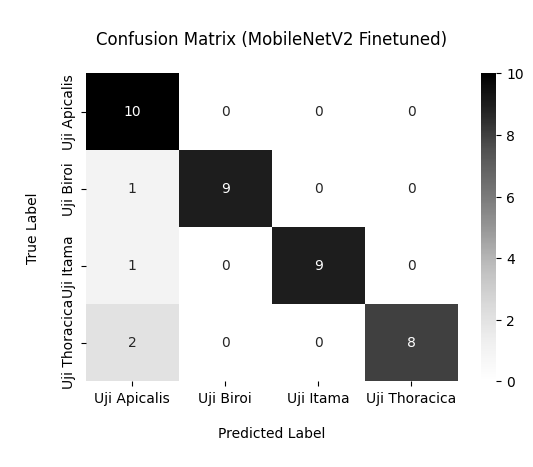

In [ ]:
print("\n--- Memuat Model Terbaik Hasil Fine-Tuning ---")

batch_size = 16
target_size = (224, 224)
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru'
try:
    # Memuat model dari path yang baru
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise


print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Data Uji Capture Resized')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print("\n--- Mengevaluasi Model pada Data Uji ---")
results = best_model.evaluate(test_generator)

print("\n" + "="*30)
print("  HASIL EVALUASI PADA DATA UJI  ")
print("="*30)
print(f"Test Loss    : {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*30 + "\n")

print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('\nConfusion Matrix (MobileNetV2 Finetuned)\n')
plt.ylabel('\nTrue Label\n')
plt.xlabel('\nPredicted Label\n')
plt.show()

In [ ]:
# Dapatkan nama-nama kelas dari generator uji yang sudah ada
class_names = list(test_generator.class_indices.keys())

print("\n" + "="*60)
print("      Tabel Classification Report MobileNetV2 (Fine-Tuned)      ")
print("="*60)

# Menggunakan output_dict=True untuk perhitungan dan tampilan DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Menampilkan report dalam bentuk tabel yang rapi
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string())

print("\n" + "="*60)
print("        Perhitungan Akurasi per Kelas dan Total Akurasi         ")
print("="*60)
print("Rumus Akurasi per Kelas (Recall): TP / (TP + FN)")
print("-" * 60)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP

    # Total sampel aktual untuk kelas ini
    total_class_samples = TP + FN

    # Akurasi per kelas (sebenarnya ini adalah Recall atau Sensitivity)
    class_accuracy = TP / total_class_samples if total_class_samples > 0 else 0

    print(f"Akurasi untuk Kelas '{class_name}':")
    print(f"  - Prediksi Benar / Total Sampel Asli = {TP}/{total_class_samples}")
    print(f"  - Persentase (Recall)                = {class_accuracy:.2%}\n")
# ---------------------------------------------------------------------------------------------

# Perhitungan total akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print("-" * 60)
print(f"Total Akurasi Keseluruhan (Overall Accuracy): {overall_accuracy:.2%}")
print("="*60)

print("\n" + "="*60)
print("       Perhitungan Precision dan Recall per Kelas dan Total       ")
print("="*60)
print("Rumus Precision : TP / (TP + FP)")
print("Rumus Recall    : TP / (TP + FN)")
print("-" * 60)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Perhitungan untuk Kelas '{class_name}':")
    print(f"  - Precision = {precision:.4f}")
    print(f"  - Recall    = {recall:.4f}\n")

# Perhitungan total precision dan recall (menggunakan macro average)
total_precision_macro = report['macro avg']['precision']
total_recall_macro = report['macro avg']['recall']

print("-" * 60)
print(f"Total Keseluruhan Precision (Macro Avg): {total_precision_macro:.2%}")
print(f"Total Keseluruhan Recall (Macro Avg):    {total_recall_macro:.2%}")
print("="*60)

# Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Label Asli': y_true,
    'Kategori Asli': nama_kategori_asli,
    'Prediksi Model': y_pred,
    'Kategori Prediksi': nama_kategori_prediksi
}

# Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# Menampilkan tabel hasil prediksi
print("\n📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:")
# Gunakan .to_string() agar semua baris ditampilkan jika data ujinya banyak
print(results_df.to_string())


      Tabel Classification Report MobileNetV2 (Fine-Tuned)      
               precision  recall  f1-score  support
Uji Apicalis    0.714286     1.0  0.833333     10.0
Uji Biroi       1.000000     0.9  0.947368     10.0
Uji Itama       1.000000     0.9  0.947368     10.0
Uji Thoracica   1.000000     0.8  0.888889     10.0
accuracy        0.900000     0.9  0.900000      0.9
macro avg       0.928571     0.9  0.904240     40.0
weighted avg    0.928571     0.9  0.904240     40.0

        Perhitungan Akurasi per Kelas dan Total Akurasi         
Rumus Akurasi per Kelas (Recall): TP / (TP + FN)
------------------------------------------------------------
Akurasi untuk Kelas 'Uji Apicalis':
  - Prediksi Benar / Total Sampel Asli = 10/10
  - Persentase (Recall)                = 100.00%

Akurasi untuk Kelas 'Uji Biroi':
  - Prediksi Benar / Total Sampel Asli = 9/10
  - Persentase (Recall)                = 90.00%

Akurasi untuk Kelas 'Uji Itama':
  - Prediksi Benar / Total Sampel Asli = 9/10
  


--- Memuat Model Terbaik Hasil Fine-Tuning ---
Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 60 images belonging to 4 classes.

--- Mengevaluasi Model pada Data Uji ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9308 - loss: 0.3649

  HASIL EVALUASI PADA DATA UJI  
Test Loss    : 0.4834
Test Accuracy: 0.9000 (90.00%)


--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Laporan Klasifikasi:

              precision    recall  f1-score   support

    Apicalis       0.71      1.00      0.83        15
       Biroi       1.00      0.87      0.93        15
       Itama       1.00      0.93      0.97        15
   Thoracica       1.00      0.80      0.89        15

    accuracy                           0.90        60
   macro avg       0.93      0.90      0.90        60
weighted avg       0.93      0.90      0.90        60


Confusion Matrix:



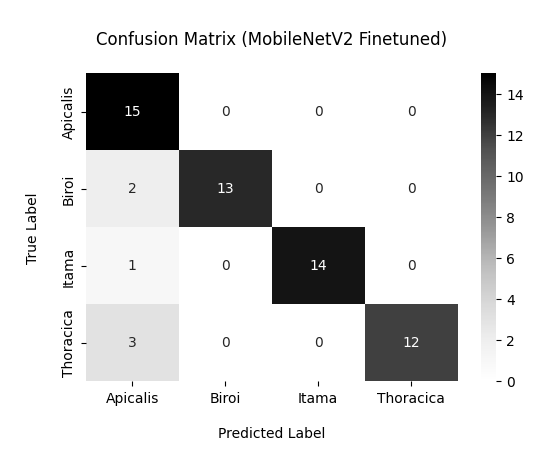

In [ ]:
print("\n--- Memuat Model Terbaik Hasil Fine-Tuning ---")

batch_size = 16
target_size = (224, 224)
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru'
try:
    # Memuat model dari path yang baru
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise


print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Uji Gabungan')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print("\n--- Mengevaluasi Model pada Data Uji ---")
results = best_model.evaluate(test_generator)

print("\n" + "="*30)
print("  HASIL EVALUASI PADA DATA UJI  ")
print("="*30)
print(f"Test Loss    : {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*30 + "\n")

print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('\nConfusion Matrix (MobileNetV2 Finetuned)\n')
plt.ylabel('\nTrue Label\n')
plt.xlabel('\nPredicted Label\n')
plt.show()

In [ ]:
# Dapatkan nama-nama kelas dari generator uji yang sudah ada
class_names = list(test_generator.class_indices.keys())

print("\n" + "="*60)
print("      Tabel Classification Report MobileNetV2 (Fine-Tuned)      ")
print("="*60)

# Menggunakan output_dict=True untuk perhitungan dan tampilan DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Menampilkan report dalam bentuk tabel yang rapi
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string())

print("\n" + "="*60)
print("        Perhitungan Akurasi per Kelas dan Total Akurasi         ")
print("="*60)
print("Rumus Akurasi per Kelas (Recall): TP / (TP + FN)")
print("-" * 60)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP

    # Total sampel aktual untuk kelas ini
    total_class_samples = TP + FN

    # Akurasi per kelas (sebenarnya ini adalah Recall atau Sensitivity)
    class_accuracy = TP / total_class_samples if total_class_samples > 0 else 0

    print(f"Akurasi untuk Kelas '{class_name}':")
    print(f"  - Prediksi Benar / Total Sampel Asli = {TP}/{total_class_samples}")
    print(f"  - Persentase (Recall)                = {class_accuracy:.2%}\n")
# ---------------------------------------------------------------------------------------------

# Perhitungan total akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print("-" * 60)
print(f"Total Akurasi Keseluruhan (Overall Accuracy): {overall_accuracy:.2%}")
print("="*60)

print("\n" + "="*60)
print("       Perhitungan Precision dan Recall per Kelas dan Total       ")
print("="*60)
print("Rumus Precision : TP / (TP + FP)")
print("Rumus Recall    : TP / (TP + FN)")
print("-" * 60)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Perhitungan untuk Kelas '{class_name}':")
    print(f"  - Precision = {precision:.4f}")
    print(f"  - Recall    = {recall:.4f}\n")

# Perhitungan total precision dan recall (menggunakan macro average)
total_precision_macro = report['macro avg']['precision']
total_recall_macro = report['macro avg']['recall']

print("-" * 60)
print(f"Total Keseluruhan Precision (Macro Avg): {total_precision_macro:.2%}")
print(f"Total Keseluruhan Recall (Macro Avg):    {total_recall_macro:.2%}")
print("="*60)

# Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Label Asli': y_true,
    'Kategori Asli': nama_kategori_asli,
    'Prediksi Model': y_pred,
    'Kategori Prediksi': nama_kategori_prediksi
}

# Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# Menampilkan tabel hasil prediksi
print("\n📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:")
# Gunakan .to_string() agar semua baris ditampilkan jika data ujinya banyak
print(results_df.to_string())


      Tabel Classification Report MobileNetV2 (Fine-Tuned)      
              precision    recall  f1-score  support
Apicalis       0.714286  1.000000  0.833333     15.0
Biroi          1.000000  0.866667  0.928571     15.0
Itama          1.000000  0.933333  0.965517     15.0
Thoracica      1.000000  0.800000  0.888889     15.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.928571  0.900000  0.904078     60.0
weighted avg   0.928571  0.900000  0.904078     60.0

        Perhitungan Akurasi per Kelas dan Total Akurasi         
Rumus Akurasi per Kelas (Recall): TP / (TP + FN)
------------------------------------------------------------
Akurasi untuk Kelas 'Apicalis':
  - Prediksi Benar / Total Sampel Asli = 15/15
  - Persentase (Recall)                = 100.00%

Akurasi untuk Kelas 'Biroi':
  - Prediksi Benar / Total Sampel Asli = 13/15
  - Persentase (Recall)                = 86.67%

Akurasi untuk Kelas 'Itama':
  - Prediksi Benar / Total Sampel Asli = 14/15
  - 


--- Memuat Model Terbaik Hasil Fine-Tuning ---
Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 60 images belonging to 4 classes.

--- Mengevaluasi Model pada Data Uji ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9308 - loss: 0.3649

  HASIL EVALUASI PADA DATA UJI  
Test Loss    : 0.4834
Test Accuracy: 0.9000 (90.00%)


--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step

Laporan Klasifikasi:

              precision    recall  f1-score   support

    Apicalis       0.71      1.00      0.83        15
       Biroi       1.00      0.87      0.93        15
       Itama       1.00      0.93      0.97        15
   Thoracica       1.00      0.80      0.89        15

    accuracy                           0.90        60
   macro avg       0.93      0.90      0.90        60
weighted avg       0.93      0.90      0.90        60


Confusion Matrix:



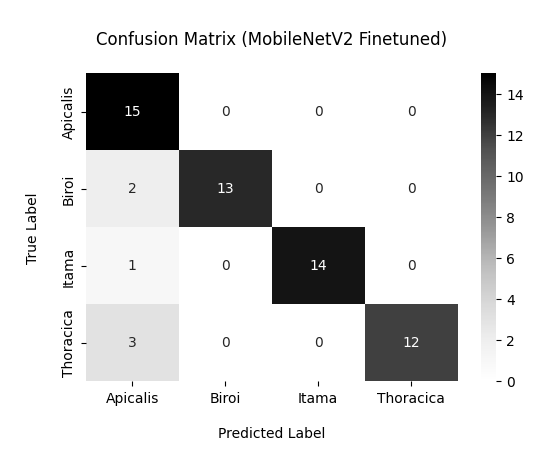

In [ ]:
#NEW UJI DATA

print("\n--- Memuat Model Terbaik Hasil Fine-Tuning ---")

batch_size = 16
target_size = (224, 224)
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru'
try:
    # Memuat model dari path yang baru
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise


print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Uji Gabungan')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print("\n--- Mengevaluasi Model pada Data Uji ---")
results = best_model.evaluate(test_generator)

print("\n" + "="*30)
print("  HASIL EVALUASI PADA DATA UJI  ")
print("="*30)
print(f"Test Loss    : {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*30 + "\n")

print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('\nConfusion Matrix (MobileNetV2 Finetuned)\n')
plt.ylabel('\nTrue Label\n')
plt.xlabel('\nPredicted Label\n')
plt.show()

# **EVALUASI DENGAN PROBABILITAS KELAS**

---Model berhasil dimuat!---

--- Memuat dan memproses satu gambar ---
Gambar berhasil diproses.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

========Hasil Evaluasi Citra Tunggal========
Citra dideteksi sebagai: Tetrigona apicalis
Score probabilitas: 69.90%
--------------------------------------

Detail Probabilitas per Kelas:
 - Tetrigona apicalis: 69.90%
 - Tetragonula biroi: 1.75%
 - Heterotrigona itama: 1.34%
 - Geniotrigona thoracica: 27.01%


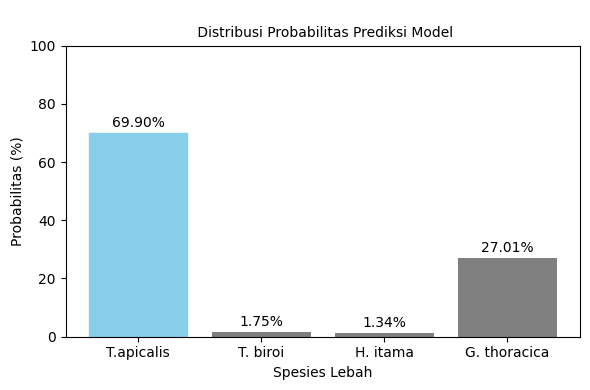

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import os

# --- Bagian 1: Definisi Path dan Parameter ---
model_path = '/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras'
image_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru/Uji Gabungan/Apicalis/a-01.jpeg'
class_names = ['Tetrigona apicalis', 'Tetragonula biroi', 'Heterotrigona itama', 'Geniotrigona thoracica']
graph_names = ['T.apicalis', 'T. biroi', 'H. itama', 'G. thoracica']
image_size = (224, 224)

if not os.path.exists(model_path):
    print(f"Error: File model tidak ditemukan di '{model_path}'")
    exit()
if not os.path.exists(image_path):
    print(f"Error: File citra tidak ditemukan di '{image_path}'")
    exit()

# --- Bagian 2: Muat Model ---
try:
    model = tf.keras.models.load_model(model_path)
    print("---Model berhasil dimuat!---")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    exit()

# --- Bagian 3: Muat & Proses Gambar Secara Langsung (Lebih Sederhana & Tepat) ---
print("\n--- Memuat dan memproses satu gambar ---")
# Memuat gambar dari file
img = load_img(image_path, target_size=image_size)
# Mengubah gambar menjadi array NumPy
img_array = img_to_array(img)
# Menambahkan dimensi batch
img_batch_expanded = np.expand_dims(img_array, axis=0)
# Menerapkan pra-pemrosesan khusus untuk MobileNetV2
img_batch = preprocess_input(img_batch_expanded)
print("Gambar berhasil diproses.")

# --- Bagian 4: Prediksi dan Tampilkan Hasil ---
predictions = model.predict(img_batch)
scores = predictions[0] * 100
predicted_class_index = np.argmax(scores)
predicted_class_name = class_names[predicted_class_index]
highest_probability = np.max(scores)

print("\n" + "="*8 + "Hasil Evaluasi Citra Tunggal" + "="*8)
print(f"Citra dideteksi sebagai: {predicted_class_name}")
print(f"Score probabilitas: {highest_probability:.2f}%")
print("--------------------------------------\n")

print("Detail Probabilitas per Kelas:")
for i in range(len(class_names)):
    print(f" - {class_names[i]}: {scores[i]:.2f}%")

# Visualisasikan probabilitas untuk semua kelas
plt.figure(figsize=(6, 4))
bars = plt.bar(graph_names, scores, color='grey')
bars[predicted_class_index].set_color('skyblue')

plt.xlabel('Spesies Lebah', fontsize=10)
plt.ylabel('Probabilitas (%)', fontsize=10)
plt.title('\n Distribusi Probabilitas Prediksi Model', fontsize=10);
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---Model berhasil dimuat!---

--- Memuat dan memproses satu gambar ---
Gambar berhasil diproses.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

========Hasil Evaluasi Citra Tunggal========
Citra dideteksi sebagai: Tetragonula biroi
Score probabilitas: 82.75%
--------------------------------------

Detail Probabilitas per Kelas:
 - Tetrigona apicalis: 2.70%
 - Tetragonula biroi: 82.75%
 - Heterotrigona itama: 8.95%
 - Geniotrigona thoracica: 5.60%


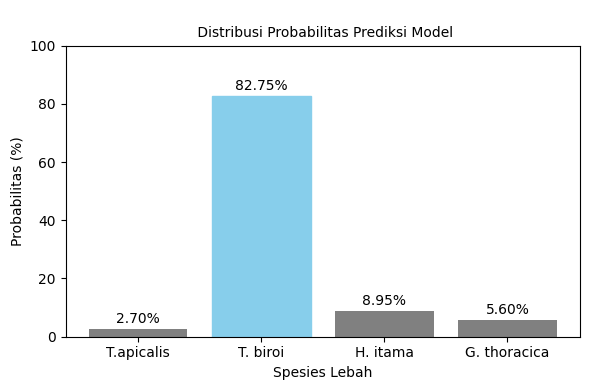

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import os

# --- Bagian 1: Definisi Path dan Parameter ---
model_path = '/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras'
image_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru/Uji Gabungan/Biroi/b-01.jpeg'
class_names = ['Tetrigona apicalis', 'Tetragonula biroi', 'Heterotrigona itama', 'Geniotrigona thoracica']
graph_names = ['T.apicalis', 'T. biroi', 'H. itama', 'G. thoracica']
image_size = (224, 224)

if not os.path.exists(model_path):
    print(f"Error: File model tidak ditemukan di '{model_path}'")
    exit()
if not os.path.exists(image_path):
    print(f"Error: File citra tidak ditemukan di '{image_path}'")
    exit()

# --- Bagian 2: Muat Model ---
try:
    model = tf.keras.models.load_model(model_path)
    print("---Model berhasil dimuat!---")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    exit()

# --- Bagian 3: Muat & Proses Gambar Secara Langsung (Lebih Sederhana & Tepat) ---
print("\n--- Memuat dan memproses satu gambar ---")
# Memuat gambar dari file
img = load_img(image_path, target_size=image_size)
# Mengubah gambar menjadi array NumPy
img_array = img_to_array(img)
# Menambahkan dimensi batch
img_batch_expanded = np.expand_dims(img_array, axis=0)
# Menerapkan pra-pemrosesan khusus untuk MobileNetV2
img_batch = preprocess_input(img_batch_expanded)
print("Gambar berhasil diproses.")

# --- Bagian 4: Prediksi dan Tampilkan Hasil ---
predictions = model.predict(img_batch)
scores = predictions[0] * 100
predicted_class_index = np.argmax(scores)
predicted_class_name = class_names[predicted_class_index]
highest_probability = np.max(scores)

print("\n" + "="*8 + "Hasil Evaluasi Citra Tunggal" + "="*8)
print(f"Citra dideteksi sebagai: {predicted_class_name}")
print(f"Score probabilitas: {highest_probability:.2f}%")
print("--------------------------------------\n")

print("Detail Probabilitas per Kelas:")
for i in range(len(class_names)):
    print(f" - {class_names[i]}: {scores[i]:.2f}%")

# Visualisasikan probabilitas untuk semua kelas
plt.figure(figsize=(6, 4))
bars = plt.bar(graph_names, scores, color='grey')
bars[predicted_class_index].set_color('skyblue')

plt.xlabel('Spesies Lebah', fontsize=10)
plt.ylabel('Probabilitas (%)', fontsize=10)
plt.title('\n Distribusi Probabilitas Prediksi Model', fontsize=10);
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---Model berhasil dimuat!---

--- Memuat dan memproses satu gambar ---
Gambar berhasil diproses.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

========Hasil Evaluasi Citra Tunggal========
Citra dideteksi sebagai: Heterotrigona itama
Score probabilitas: 98.16%
--------------------------------------

Detail Probabilitas per Kelas:
 - Tetrigona apicalis: 0.40%
 - Tetragonula biroi: 0.44%
 - Heterotrigona itama: 98.16%
 - Geniotrigona thoracica: 1.00%


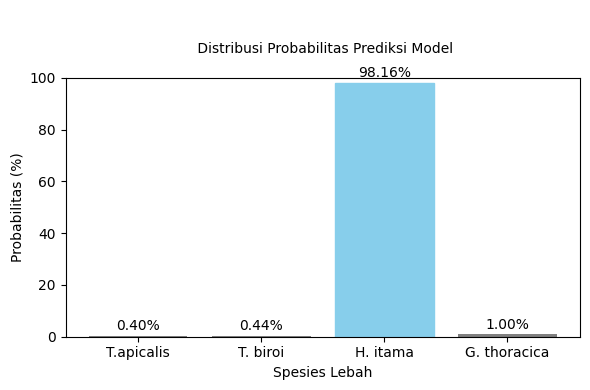

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import os

# --- Bagian 1: Definisi Path dan Parameter ---
model_path = '/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras'
image_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru/Uji Gabungan/Itama/i-02.jpg'
class_names = ['Tetrigona apicalis', 'Tetragonula biroi', 'Heterotrigona itama', 'Geniotrigona thoracica']
graph_names = ['T.apicalis', 'T. biroi', 'H. itama', 'G. thoracica']
image_size = (224, 224)

if not os.path.exists(model_path):
    print(f"Error: File model tidak ditemukan di '{model_path}'")
    exit()
if not os.path.exists(image_path):
    print(f"Error: File citra tidak ditemukan di '{image_path}'")
    exit()

# --- Bagian 2: Muat Model ---
try:
    model = tf.keras.models.load_model(model_path)
    print("---Model berhasil dimuat!---")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    exit()

# --- Bagian 3: Muat & Proses Gambar Secara Langsung (Lebih Sederhana & Tepat) ---
print("\n--- Memuat dan memproses satu gambar ---")
# Memuat gambar dari file
img = load_img(image_path, target_size=image_size)
# Mengubah gambar menjadi array NumPy
img_array = img_to_array(img)
# Menambahkan dimensi batch
img_batch_expanded = np.expand_dims(img_array, axis=0)
# Menerapkan pra-pemrosesan khusus untuk MobileNetV2
img_batch = preprocess_input(img_batch_expanded)
print("Gambar berhasil diproses.")

# --- Bagian 4: Prediksi dan Tampilkan Hasil ---
predictions = model.predict(img_batch)
scores = predictions[0] * 100
predicted_class_index = np.argmax(scores)
predicted_class_name = class_names[predicted_class_index]
highest_probability = np.max(scores)

print("\n" + "="*8 + "Hasil Evaluasi Citra Tunggal" + "="*8)
print(f"Citra dideteksi sebagai: {predicted_class_name}")
print(f"Score probabilitas: {highest_probability:.2f}%")
print("--------------------------------------\n")

print("Detail Probabilitas per Kelas:")
for i in range(len(class_names)):
    print(f" - {class_names[i]}: {scores[i]:.2f}%")

# Visualisasikan probabilitas untuk semua kelas
plt.figure(figsize=(6, 4))
bars = plt.bar(graph_names, scores, color='grey')
bars[predicted_class_index].set_color('skyblue')

plt.xlabel('Spesies Lebah', fontsize=10)
plt.ylabel('Probabilitas (%)', fontsize=10)
plt.title('\n\n Distribusi Probabilitas Prediksi Model\n', fontsize=10);
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---Model berhasil dimuat!---

--- Memuat dan memproses satu gambar ---
Gambar berhasil diproses.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

========Hasil Evaluasi Citra Tunggal========
Citra dideteksi sebagai: Geniotrigona thoracica
Score probabilitas: 53.55%
--------------------------------------

Detail Probabilitas per Kelas:
 - Tetrigona apicalis: 37.30%
 - Tetragonula biroi: 1.14%
 - Heterotrigona itama: 8.00%
 - Geniotrigona thoracica: 53.55%


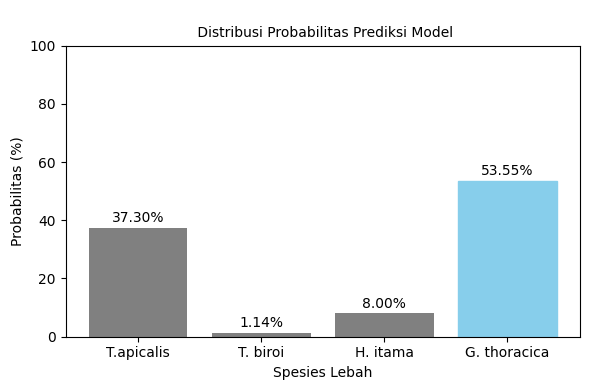

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import os

# --- Bagian 1: Definisi Path dan Parameter ---
model_path = '/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras'
image_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru/Uji Gabungan/Thoracica/t-02.jpeg'
class_names = ['Tetrigona apicalis', 'Tetragonula biroi', 'Heterotrigona itama', 'Geniotrigona thoracica']
graph_names = ['T.apicalis', 'T. biroi', 'H. itama', 'G. thoracica']
image_size = (224, 224)

if not os.path.exists(model_path):
    print(f"Error: File model tidak ditemukan di '{model_path}'")
    exit()
if not os.path.exists(image_path):
    print(f"Error: File citra tidak ditemukan di '{image_path}'")
    exit()

# --- Bagian 2: Muat Model ---
try:
    model = tf.keras.models.load_model(model_path)
    print("---Model berhasil dimuat!---")
except Exception as e:
    print(f"Error saat memuat model: {e}")
    exit()

# --- Bagian 3: Muat & Proses Gambar Secara Langsung (Lebih Sederhana & Tepat) ---
print("\n--- Memuat dan memproses satu gambar ---")
# Memuat gambar dari file
img = load_img(image_path, target_size=image_size)
# Mengubah gambar menjadi array NumPy
img_array = img_to_array(img)
# Menambahkan dimensi batch
img_batch_expanded = np.expand_dims(img_array, axis=0)
# Menerapkan pra-pemrosesan khusus untuk MobileNetV2
img_batch = preprocess_input(img_batch_expanded)
print("Gambar berhasil diproses.")

# --- Bagian 4: Prediksi dan Tampilkan Hasil ---
predictions = model.predict(img_batch)
scores = predictions[0] * 100
predicted_class_index = np.argmax(scores)
predicted_class_name = class_names[predicted_class_index]
highest_probability = np.max(scores)

print("\n" + "="*8 + "Hasil Evaluasi Citra Tunggal" + "="*8)
print(f"Citra dideteksi sebagai: {predicted_class_name}")
print(f"Score probabilitas: {highest_probability:.2f}%")
print("--------------------------------------\n")

print("Detail Probabilitas per Kelas:")
for i in range(len(class_names)):
    print(f" - {class_names[i]}: {scores[i]:.2f}%")

# Visualisasikan probabilitas untuk semua kelas
plt.figure(figsize=(6, 4))
bars = plt.bar(graph_names, scores, color='grey')
bars[predicted_class_index].set_color('skyblue')

plt.xlabel('Spesies Lebah', fontsize=10)
plt.ylabel('Probabilitas (%)', fontsize=10)
plt.title('\n Distribusi Probabilitas Prediksi Model', fontsize=10);
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1.0, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

batch_size = 16
target_size = (224, 224)
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized'

try:
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise

print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Uji')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print(f"Ditemukan {test_generator.samples} gambar di {test_generator.num_classes} kelas.")

print("\n--- Memprediksi seluruh data uji... ---")
all_predictions = best_model.predict(test_generator)
predicted_indices = np.argmax(all_predictions, axis=1)

class_names = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
filenames = test_generator.filenames

results_list = []
for i in range(len(filenames)):
    file_name = os.path.splitext(os.path.basename(filenames[i]))[0]
    data_row = {
        'File': file_name,
        'Label Asli': class_names[true_indices[i]],
        'Hasil Prediksi': class_names[predicted_indices[i]],
        'Score (%)': f"{np.max(all_predictions[i]) * 100:.2f}"
    }
    for j, name in enumerate(class_names):
        data_row[f'Prob. {name} (%)'] = f"{all_predictions[i][j] * 100:.2f}"
    results_list.append(data_row)

if results_list:
    df = pd.DataFrame(results_list)

    # 1. Buat kolom 'Label Asli' menjadi kategorikal untuk diurutkan
    df['Label Asli'] = pd.Categorical(df['Label Asli'], categories=class_names, ordered=True)
    # 2. Buat kunci urutan dari angka yang ada di nama file
    df['sort_key'] = df['File'].str.extract(r'(\d+)').astype(int)
    # 3. Urutkan berdasarkan 'Label Asli', lalu berdasarkan kunci urutan file
    df.sort_values(by=['Label Asli', 'sort_key'], inplace=True)
    # 4. Hapus kolom bantu dan reset index
    df.drop(columns='sort_key', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Atur ulang urutan kolom untuk tampilan
    prob_columns = [col for col in df.columns if 'Prob.' in col]
    column_order = ['File', 'Label Asli', 'Hasil Prediksi', 'Score (%)'] + sorted(prob_columns)
    df = df[column_order]

    print("\n" + "="*42 + "TABEL HASIL EVALUASI KESELURUHAN" + "="*42 + "\n")
    print(df.to_string())
    print("="*75)

    output_dir = '/content/drive/MyDrive/Skripsi/Log Evaluasi Model/'
    output_filename = 'log_probability_mobilenetv2(fine_tuning).csv'
    output_path = os.path.join(output_dir, output_filename)

    # Membuat direktori jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    # Menyimpan DataFrame ke file CSV
    df.to_csv(output_path, index=False)

    print(f"\nHasil evaluasi berhasil disimpan ke:\n   {output_path}")

    # Hitung ringkasan akurasi dari DataFrame
    correct_predictions = (df['Label Asli'] == df['Hasil Prediksi']).sum()
    total_images = len(df)
    accuracy = (correct_predictions / total_images) * 100

    print("\n------RINGKASAN AKURASI------")
    print(f"  Total Gambar Diuji\t: {total_images}")
    print(f"  Prediksi Benar\t: {correct_predictions}")
    print(f"  Prediksi Salah\t: {total_images - correct_predictions}")
    print(f"  Akurasi Model\t\t: {accuracy:.2f}%")
    print("="*54)
else:
    print("\nTidak ada data untuk ditampilkan.")

Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 80 images belonging to 4 classes.
Ditemukan 80 gambar di 4 kelas.

--- Memprediksi seluruh data uji... ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step

==========================================TABEL HASIL EVALUASI KESELURUHAN==========================================

      File Label Asli Hasil Prediksi Score (%) Prob. Apicalis (%) Prob. Biroi (%) Prob. Itama (%) Prob. Thoracica (%)
0   au-001   Apicalis       Apicalis     99.86              99.86            0.05            0.00                0.09
1   au-002   Apicalis       Apicalis     81.81              81.81           16.04            0.33                1.81
2   au-003   Apicalis       Apicalis     93.43              93.43            5.49            0.48                0.60
3   au-004   Apicalis          Biroi     50.38              48.40           50.38            0.19                1.03
4   au-005   Apicalis       Apicalis     89.29              89.29            0.08            0.02               10.61
5   au-006   Apicalis       Apicalis     99.45              99.45            0.13            0.09                0.33
6   au-007   Apic

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. PERSIAPAN PATH DAN PARAMETER
batch_size = 16
target_size = (224, 224)
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (fine_tuning)/best_model_finetuned.keras'
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Data Uji Baru'

# 2. MEMUAT MODEL
try:
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise

# 3. MENYIAPKAN GENERATOR DATA UJI
print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Uji Gabungan')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print(f"Ditemukan {test_generator.samples} gambar di {test_generator.num_classes} kelas.")

print("\n--- Memprediksi seluruh data uji... ---")
all_predictions = best_model.predict(test_generator)
predicted_indices = np.argmax(all_predictions, axis=1)

class_names = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
filenames = test_generator.filenames

results_list = []
for i in range(len(filenames)):
    file_name = os.path.splitext(os.path.basename(filenames[i]))[0]
    data_row = {
        'File': file_name,
        'Label Asli': class_names[true_indices[i]],
        'Hasil Prediksi': class_names[predicted_indices[i]],
        'Score (%)': f"{np.max(all_predictions[i]) * 100:.2f}"
    }
    for j, name in enumerate(class_names):
        data_row[f'Prob. {name} (%)'] = f"{all_predictions[i][j] * 100:.2f}"
    results_list.append(data_row)

if results_list:
    df = pd.DataFrame(results_list)

    # 1. Buat kolom 'Label Asli' menjadi kategorikal untuk diurutkan
    df['Label Asli'] = pd.Categorical(df['Label Asli'], categories=class_names, ordered=True)
    # 2. Buat kunci urutan dari angka yang ada di nama file
    df['sort_key'] = df['File'].str.extract(r'(\d+)').astype(int)
    # 3. Urutkan berdasarkan 'Label Asli', lalu berdasarkan kunci urutan file
    df.sort_values(by=['Label Asli', 'sort_key'], inplace=True)
    # 4. Hapus kolom bantu dan reset index
    df.drop(columns='sort_key', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Atur ulang urutan kolom untuk tampilan
    prob_columns = [col for col in df.columns if 'Prob.' in col]
    column_order = ['File', 'Label Asli', 'Hasil Prediksi', 'Score (%)'] + sorted(prob_columns)
    df = df[column_order]

    print("\n" + "="*42 + "TABEL HASIL EVALUASI KESELURUHAN" + "="*42 + "\n")
    print(df.to_string())
    print("="*75)

    output_dir = '/content/drive/MyDrive/Skripsi/Log Evaluasi Model/'
    output_filename = 'log_probability_mobilenetv2(data baru).csv'
    output_path = os.path.join(output_dir, output_filename)

    # Membuat direktori jika belum ada
    os.makedirs(output_dir, exist_ok=True)

    # Menyimpan DataFrame ke file CSV
    df.to_csv(output_path, index=False)

    print(f"\nHasil evaluasi berhasil disimpan ke:\n   {output_path}")

    # Hitung ringkasan akurasi dari DataFrame
    correct_predictions = (df['Label Asli'] == df['Hasil Prediksi']).sum()
    total_images = len(df)
    accuracy = (correct_predictions / total_images) * 100

    print("\n------RINGKASAN AKURASI------")
    print(f"  Total Gambar Diuji\t: {total_images}")
    print(f"  Prediksi Benar\t: {correct_predictions}")
    print(f"  Prediksi Salah\t: {total_images - correct_predictions}")
    print(f"  Akurasi Model\t\t: {accuracy:.2f}%")
    print("="*54)
else:
    print("\nTidak ada data untuk ditampilkan.")

Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (fine_tuning)/best_model_finetuned.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 60 images belonging to 4 classes.
Ditemukan 60 gambar di 4 kelas.

--- Memprediksi seluruh data uji... ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 532ms/step

==========================================TABEL HASIL EVALUASI KESELURUHAN==========================================

    File Label Asli Hasil Prediksi Score (%) Prob. Apicalis (%) Prob. Biroi (%) Prob. Itama (%) Prob. Thoracica (%)
0   a-01   Apicalis       Apicalis     69.90              69.90            1.75            1.34               27.01
1   a-02   Apicalis       Apicalis     93.75              93.75            0.01            0.01                6.23
2   a-03   Apicalis       Apicalis     91.75              91.75            2.62            1.51                4.11
3   a-04   Apicalis       Apicalis     98.14              98.14            0.02            0.01                1.83
4   a-05   Apicalis       Apicalis     65.64              65.64           10.15           17.04                7.17
5   a-06   Apicalis       Apicalis     98.20              98.20            0.52            0.01                1.27
6   a-07   Apicalis       Apic

#**FINE TUNING MOBILENETV2 + LR SCHEDULER**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
import os
import time

tf.random.set_seed(42)
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')
target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 50

train_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2, shear_range=0.2, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=target_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False
model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')])

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

save_dir_mobilenet = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (finetuned + lr_scheduler)/'
os.makedirs(save_dir_mobilenet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_mobilenet, "best_model_lrscheduler.keras")
filepath_log = os.path.join(save_dir_mobilenet, "training_log_lrscheduler.csv")

# Menyiapkan Callbacks
print("\n--- Menyiapkan Callbacks dengan Learning Rate Scheduler ---")
checkpoint_mobilenet = ModelCheckpoint(filepath=filepath_checkpoint, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
csv_logger_mobilenet = CSVLogger(filename=filepath_log)
early_stopping_mobilenet = EarlyStopping(monitor='val_accuracy', patience=7, mode='max', verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
callbacks_list = [checkpoint_mobilenet, csv_logger_mobilenet, early_stopping_mobilenet, reduce_lr]
print("Callbacks telah siap.")

print("\n--- Memulai Pelatihan ---")
start_time = time.time()

history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list)
print("Pelatihan selesai.")

Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Menyiapkan Callbacks dengan Learning Rate Scheduler ---
Callbacks telah siap.

--- Memulai Pelatihan ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.3428 - loss: 1.8047
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (finetuned + lr_scheduler)/best_model_lrscheduler.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 991ms/step - accuracy: 0.3439 - loss: 1.8001 - val_accuracy: 0.5375 - val_loss: 1.1405 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.5192 - loss: 1.2500
Epoch 2: val_accuracy improved from 0.53750 to 0.60000, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (finetuned + lr_scheduler)/best_model_lrscheduler.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 910ms/step - accuracy: 0.5198 - loss: 1.2470 - val_accuracy: 0.6000 - val_loss: 0.9979 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.6169 - loss: 0.9521
Epoch 3: val_accuracy improved from 0.60000 to 0.62500, saving model to /content/

In [ ]:
import numpy as np

# --- Menghitung Waktu dan Metrik Utama ---
end_time = time.time()
total_time = end_time - start_time  # <--- HITUNG TOTAL WAKTU

# Menggunakan variabel history yang benar dari pelatihan di atas
num_actual_epochs = len(history_mobilenet.history['loss'])

# <--- HITUNG WAKTU RATA-RATA PER EPOCH ---
avg_time_per_epoch = total_time / num_actual_epochs if num_actual_epochs > 0 else 0

# Mengambil metrik terbaik dari objek history
best_val_acc = max(history_mobilenet.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_mobilenet.history['val_accuracy']) + 1
lowest_val_loss = min(history_mobilenet.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_mobilenet.history['val_loss']) + 1


# --- Menampilkan Rangkuman ---
print("\n" + "="*55)
print(" RANGKUMAN PELATIHAN ".center(55, "="))
print("="*55)
print(f"Batch Size                 : {batch_size}")
print(f"Optimizer                  : Adam (Initial LR: 0.001, with ReduceLROnPlateau)")
print("-" * 55)
print(f"Val Accuracy Tertinggi     : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah          : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")

# <--- TAMBAHKAN BARIS-BARIS INI UNTUK MENAMPILKAN WAKTU ---
print(f"Total Waktu Pelatihan      : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu per Epoch (rata-rata): {avg_time_per_epoch:.2f} detik")

# Dapatkan ukuran file model terbaik dari path checkpoint
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik       : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")
print("="*55)


================= RANGKUMAN PELATIHAN =================
Batch Size                 : 16
Optimizer                  : Adam (Initial LR: 0.001, with ReduceLROnPlateau)
-------------------------------------------------------
Val Accuracy Tertinggi     : 0.8250 (di Epoch ke-15)
Val Loss Terendah          : 0.6346 (di Epoch ke-21)
Total Waktu Pelatihan      : 16 menit 0.95 detik
Waktu per Epoch (rata-rata): 43.68 detik
Ukuran Model Terbaik       : 9.23 MB


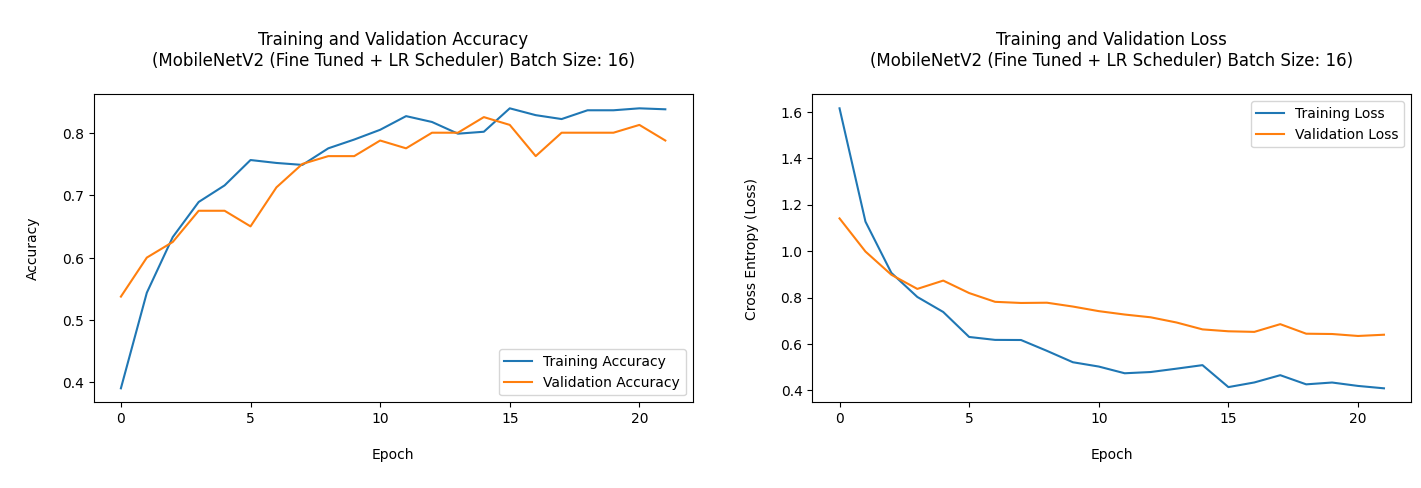

In [ ]:
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat grafik akurasi dan loss tanpa titik poin dan grid.
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # --- Grafik Akurasi (Diperbaiki) ---
    plt.subplot(1, 2, 1)
    # Menghilangkan 'o-' untuk menghapus titik poin
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy\n({model_name} (Fine Tuned + LR Scheduler) Batch Size: {bs})\n')
    plt.ylabel('\nAccuracy\n')
    plt.xlabel('\nEpoch\n')
    # Menghapus plt.grid(True)

    # --- Grafik Loss (Diperbaiki) ---
    plt.subplot(1, 2, 2)
    # Menghilangkan 'o-' untuk menghapus titik poin
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss\n({model_name} (Fine Tuned + LR Scheduler) Batch Size: {bs})\n')
    plt.ylabel('\nCross Entropy (Loss)\n')
    plt.xlabel('\nEpoch\n')
    # Menghapus plt.grid(True)

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

plot_history_side_by_side(history_mobilenet, "MobileNetV2", batch_size)


--- Memuat Model Terbaik dari Pelatihan Terbaru ---
Model berhasil dimuat dari: /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 (finetuned + lr_scheduler)/best_model_lrscheduler.keras

--- Menyiapkan Generator untuk Data Uji ---
Found 80 images belonging to 4 classes.

--- Mengevaluasi Model pada Data Uji ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - accuracy: 0.8208 - loss: 0.5480

  HASIL EVALUASI PADA DATA UJI  
Test Loss    : 0.4653
Test Accuracy: 0.8375 (83.75%)


--- Membuat Laporan Klasifikasi dan Confusion Matrix ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

Laporan Klasifikasi:

              precision    recall  f1-score   support

    Apicalis       0.82      0.70      0.76        20
       Biroi       0.74      0.85      0.79        20
       Itama       0.95      0.95      0.95        20
   Thoracica       0.85      0.85      0.85        20

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80


Confusion Matrix:



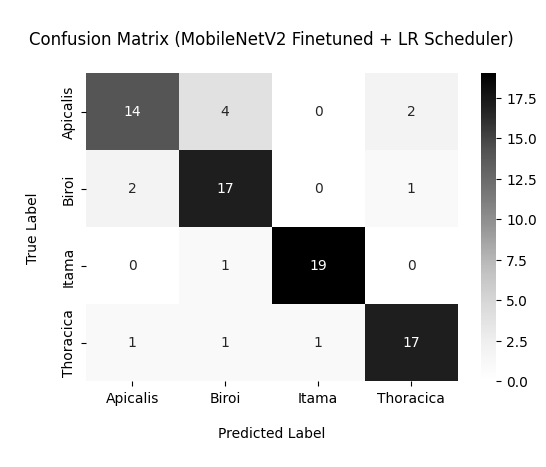

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Pastikan variabel-variabel dari sel pelatihan tersedia, seperti:
# main_path, target_size, batch_size, preprocess_input

# -----------------------------------------------------------------------------
# BAGIAN 1: MEMUAT MODEL TERBAIK & MENYIAPKAN DATA UJI
# -----------------------------------------------------------------------------
print("\n--- Memuat Model Terbaik dari Pelatihan Terbaru ---")

# Path disesuaikan dengan folder penyimpanan dari skrip pelatihan terakhir Anda.
batch_size = 16
model_path = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} (finetuned + lr_scheduler)/best_model_lrscheduler.keras'

try:
    # Memuat model dari path yang telah disesuaikan
    best_model = tf.keras.models.load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
except Exception as e:
    print(f"Gagal memuat model dari '{model_path}': {e}")
    raise

print("\n--- Menyiapkan Generator untuk Data Uji ---")
test_dir = os.path.join(main_path, 'Uji')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


# -----------------------------------------------------------------------------
# BAGIAN 2: EVALUASI KUANTITATIF (LOSS & ACCURACY)
# -----------------------------------------------------------------------------
print("\n--- Mengevaluasi Model pada Data Uji ---")
results = best_model.evaluate(test_generator)

print("\n" + "="*30)
print("  HASIL EVALUASI PADA DATA UJI  ")
print("="*30)
print(f"Test Loss    : {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*30 + "\n")


# -----------------------------------------------------------------------------
# BAGIAN 3: ANALISIS KUALITATIF (LAPORAN & CONFUSION MATRIX)
# -----------------------------------------------------------------------------
print("\n--- Membuat Laporan Klasifikasi dan Confusion Matrix ---")

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\nLaporan Klasifikasi:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('\nConfusion Matrix (MobileNetV2 Finetuned + LR Scheduler)\n')
plt.ylabel('\nTrue Label\n')
plt.xlabel('\nPredicted Label\n')
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Pastikan variabel-variabel ini sudah ada dari sel evaluasi sebelumnya:
# y_true, y_pred, cm, test_generator

# ====================================================================
# BAGIAN 1: TABEL CLASSIFICATION REPORT
# ====================================================================
# Dapatkan nama-nama kelas dari generator uji
class_names = list(test_generator.class_indices.keys())

print("\n" + "="*65)
# Judul disesuaikan untuk mencerminkan pelatihan dengan LR Scheduler
print("      Tabel Classification Report MobileNetV2 (LR Scheduler)       ")
print("="*65)

# Menggunakan output_dict=True untuk perhitungan dan tampilan DataFrame
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Menampilkan report dalam bentuk tabel yang rapi
report_df = pd.DataFrame(report).transpose()
print(report_df.to_string())


# ====================================================================
# BAGIAN 2: PERHITUNGAN RINCI AKURASI
# ====================================================================
print("\n" + "="*65)
print("         Perhitungan Akurasi per Kelas dan Total Akurasi           ")
print("="*65)
print("Rumus Akurasi per Kelas (Recall): TP / (TP + FN)")
print("-" * 65)

for i, class_name in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP

    # Total sampel aktual untuk kelas ini
    total_class_samples = TP + FN

    # Akurasi per kelas (sebenarnya ini adalah Recall atau Sensitivity)
    class_accuracy = TP / total_class_samples if total_class_samples > 0 else 0

    print(f"Akurasi untuk Kelas '{class_name}':")
    print(f"  - Prediksi Benar / Total Sampel Asli = {TP}/{total_class_samples}")
    print(f"  - Persentase (Recall)                = {class_accuracy:.2%}\n")

# Perhitungan total akurasi keseluruhan
overall_accuracy = accuracy_score(y_true, y_pred)
print("-" * 65)
print(f"Total Akurasi Keseluruhan (Overall Accuracy): {overall_accuracy:.2%}")
print("="*65)


# ====================================================================
# BAGIAN 3: PERHITUNGAN RINCI PRECISION & RECALL
# ====================================================================
print("\n" + "="*65)
print("        Perhitungan Precision dan Recall per Kelas dan Total         ")
print("="*65)
print("Rumus Precision : TP / (TP + FP)")
print("Rumus Recall    : TP / (TP + FN)")
print("-" * 65)

for class_name in class_names:
    precision = report[class_name]['precision']
    recall = report[class_name]['recall']

    print(f"Perhitungan untuk Kelas '{class_name}':")
    print(f"  - Precision = {precision:.4f}")
    print(f"  - Recall    = {recall:.4f}\n")

# Perhitungan total precision dan recall (menggunakan macro average)
total_precision_macro = report['macro avg']['precision']
total_recall_macro = report['macro avg']['recall']

print("-" * 65)
print(f"Total Keseluruhan Precision (Macro Avg): {total_precision_macro:.2%}")
print(f"Total Keseluruhan Recall (Macro Avg):    {total_recall_macro:.2%}")
print("="*65)


# ====================================================================
# BAGIAN 4: TABEL PERBANDINGAN PREDIKSI VS LABEL ASLI
# ====================================================================
# Mengonversi label indeks menjadi nama kategori yang sesuai
nama_kategori_asli = [class_names[i] for i in y_true]
nama_kategori_prediksi = [class_names[i] for i in y_pred]

# Membuat dictionary yang berisi semua data yang akan ditampilkan
results_dict = {
    'Label Asli': y_true,
    'Kategori Asli': nama_kategori_asli,
    'Prediksi Model': y_pred,
    'Kategori Prediksi': nama_kategori_prediksi
}

# Membuat DataFrame pandas dari dictionary
results_df = pd.DataFrame(results_dict)

# Menampilkan tabel hasil prediksi
print("\n📊 Tabel Hasil Prediksi Model vs Label Asli pada Data Uji:")
# Gunakan .to_string() agar semua baris ditampilkan jika data ujinya banyak
print(results_df.to_string())


      Tabel Classification Report MobileNetV2 (LR Scheduler)       
              precision  recall  f1-score  support
Apicalis       0.823529  0.7000  0.756757  20.0000
Biroi          0.739130  0.8500  0.790698  20.0000
Itama          0.950000  0.9500  0.950000  20.0000
Thoracica      0.850000  0.8500  0.850000  20.0000
accuracy       0.837500  0.8375  0.837500   0.8375
macro avg      0.840665  0.8375  0.836864  80.0000
weighted avg   0.840665  0.8375  0.836864  80.0000

         Perhitungan Akurasi per Kelas dan Total Akurasi           
Rumus Akurasi per Kelas (Recall): TP / (TP + FN)
-----------------------------------------------------------------
Akurasi untuk Kelas 'Apicalis':
  - Prediksi Benar / Total Sampel Asli = 14/20
  - Persentase (Recall)                = 70.00%

Akurasi untuk Kelas 'Biroi':
  - Prediksi Benar / Total Sampel Asli = 17/20
  - Persentase (Recall)                = 85.00%

Akurasi untuk Kelas 'Itama':
  - Prediksi Benar / Total Sampel Asli = 19/20
  - Persen

# **UJI COBA LATIH MODEL DENGAN PIXEL (64x64)**

MODEL MOBILENETV2

In [ ]:
# Menambahkan Random Seed
tf.random.set_seed(42)

# Pengaturan Location Path
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Resized 64x64/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

target_size = (128, 128)
input_shape = (128, 128, 3)
target_class = 4
batch_size = 16
epochs = 50
histories_mobilenet = {}

# Menyiapkan Data Generator
print("\n--- Menyiapkan Data Generator ---")
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)

# Membangun Arsitektur Model
print("\n--- Membangun Arsitektur MobileNetV2 ---")
base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False
model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')])
print("Arsitektur MobileNetV2 selesai dibangun.")

# Menyiapkan Callbacks
print("\n--- Menyiapkan Callbacks ---")

save_dir_mobilenet = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_{batch_size} 64px/'
os.makedirs(save_dir_mobilenet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_mobilenet, "best_model.keras")
filepath_log = os.path.join(save_dir_mobilenet, "training_log.csv")

checkpoint_mobilenet = ModelCheckpoint(
    filepath=filepath_checkpoint,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

csv_logger_mobilenet = CSVLogger(filepath_log)

early_stopping_mobilenet = EarlyStopping(
    monitor='val_accuracy',
    patience=7, mode='max',
    verbose=1,
    restore_best_weights=True)

print("✅ Callbacks telah siap.")


--- Menyiapkan Data Generator ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Membangun Arsitektur MobileNetV2 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Arsitektur MobileNetV2 selesai dibangun.

--- Menyiapkan Callbacks ---
✅ Callbacks telah siap.


In [ ]:
# Periksa dan Compile Model Summary
print("\n--- Menglompilasi Model MobileNetV2 ---")
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()


--- Menglompilasi Model MobileNetV2 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Training Model Fit MobileNetV2
print(f"\n--- Memulai Pelatihan Model MobileNetV2 (Batch Size: {batch_size}, Epochs: {epochs}) ---")

start_time = time.time()
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_mobilenet, csv_logger_mobilenet, early_stopping_mobilenet])

print(f"\n\n Pelatihan MobileNetV2 Selesai!")
histories_mobilenet[f'bs{batch_size}_epochs{epochs}'] = history_mobilenet.history


--- Memulai Pelatihan Model MobileNetV2 (Batch Size: 16, Epochs: 50) ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2961 - loss: 2.1355
Epoch 1: val_accuracy improved from -inf to 0.46250, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 64px/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - accuracy: 0.2970 - loss: 2.1302 - val_accuracy: 0.4625 - val_loss: 1.5596
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.4195 - loss: 1.6211
Epoch 2: val_accuracy improved from 0.46250 to 0.52500, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2/bs_16 64px/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.4199 - loss: 1.6191 - val_accuracy: 0.5250 - val_loss: 1.1074
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4770 - loss: 1.3657
Epoch 3: val_accuracy did not improve from 0.52500
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.4772 - loss: 1.3655 - val_accuracy: 0.5000 - val_loss: 1.1834
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━

In [ ]:
# Menghitung Waktu dan Ukuran File
end_time = time.time()
total_time = end_time - start_time
num_actual_epochs = len(history_mobilenet.history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(history_mobilenet.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_mobilenet.history['val_accuracy']) + 1
lowest_val_loss = min(history_mobilenet.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_mobilenet.history['val_loss']) + 1

print("RANGKUMAN PELATIHAN")
print("-" * 40)
print(f"Batch Size             : {batch_size}")
print(f"Optimizer              : Adam (LR: 0.001)")
print("-" * 40)
print(f"Val Accuracy Tertinggi : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah      : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Waktu Pelatihan  : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu per Epoch        : {avg_time_per_epoch:.2f} detik")


# Dapatkan ukuran file model terbaik
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik   : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")

RANGKUMAN PELATIHAN
----------------------------------------
Batch Size             : 16
Optimizer              : Adam (LR: 0.001)
----------------------------------------
Val Accuracy Tertinggi : 0.6750 (di Epoch ke-20)
Val Loss Terendah      : 0.8749 (di Epoch ke-26)
Total Waktu Pelatihan  : 22 menit 6.97 detik
Waktu per Epoch        : 49.15 detik
Ukuran Model Terbaik   : 9.23 MB


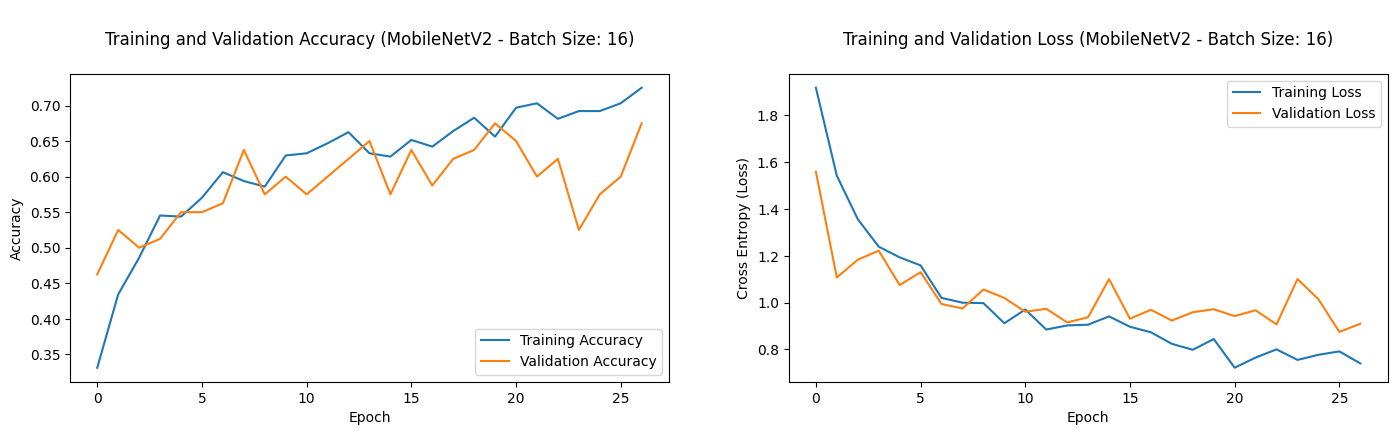

In [ ]:
# Menampilkan Grafik Akurasi dan Loss MobileNetV2
import matplotlib.pyplot as plt
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat dua grafik bersebelahan dalam satu gambar:
    1. Grafik Akurasi (Training vs Validasi)
    2. Grafik Loss (Training vs Validasi)
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Cross Entropy (Loss)')
    plt.xlabel('Epoch')

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

plot_history_side_by_side(history_mobilenet, "MobileNetV2", batch_size)

#**RESIZE TRAINING ON THE FLY MOBILENETV2**


--- Menyiapkan Data Generator ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Membangun Arsitektur MobileNetV2 ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Arsitektur MobileNetV2 selesai dibangun.

--- Menyiapkan Callbacks ---
✅ Callbacks telah siap.

--- Mengompilasi Model MobileNetV2 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Memulai Pelatihan Model MobileNetV2 (Batch Size: 16, Epochs: 50) ---
INFO: Gambar akan di-resize menjadi 224x224 secara On-The-Fly selama pelatihan.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.3671 - loss: 1.6723 
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 495s 12s/step - accuracy: 0.3681 - loss: 1.6680 - val_accuracy: 0.5375 - val_loss: 1.0252
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5621 - loss: 1.1135
Epoch 2: val_accuracy improved from 0.53750 to 0.63750, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5630 - loss: 1.1115 - val_accuracy: 0.6375 - val_loss: 0.8519
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5669 - loss: 1.0114
Epoch 3: val_accuracy improved from 0.63750 to 0.71250, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.56

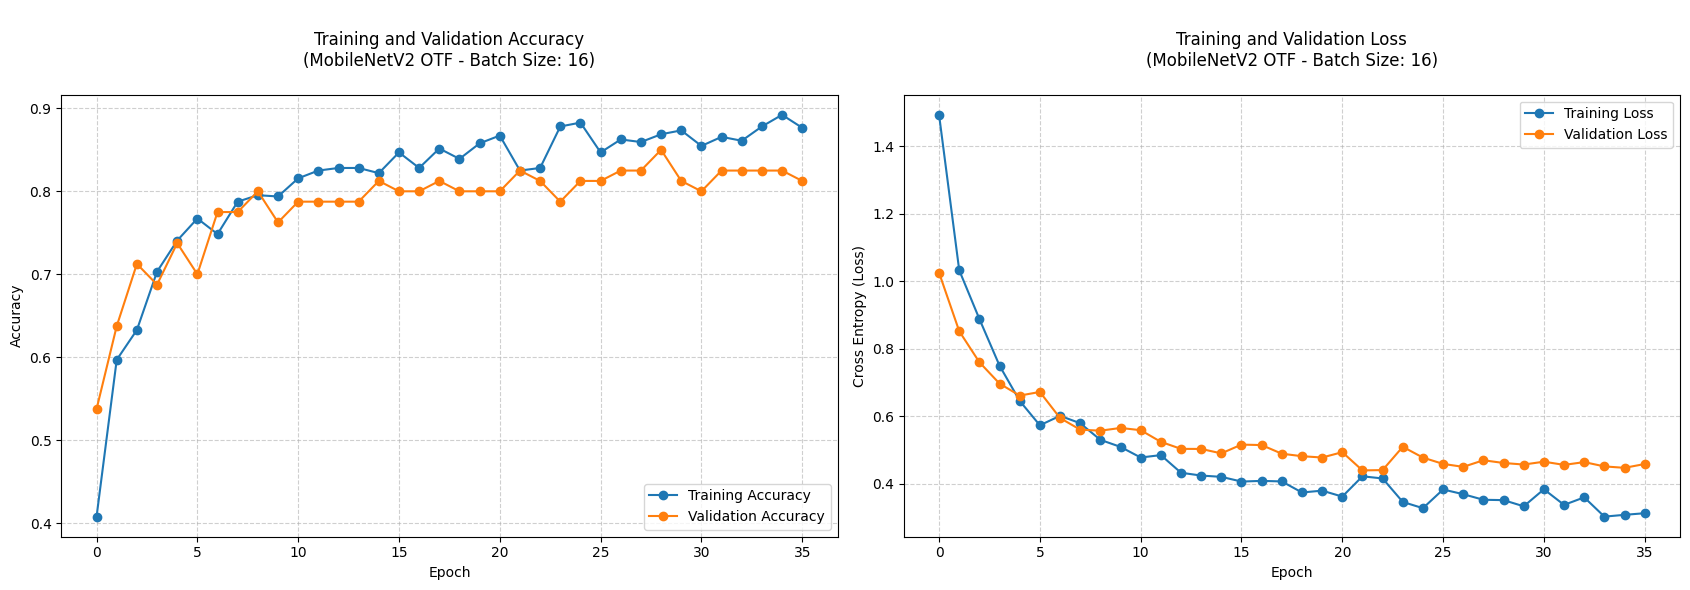

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# Menambahkan Random Seed
tf.random.set_seed(42)

# [DIUBAH] Pengaturan Location Path
# Arahkan ke folder dataset asli (resolusi penuh), bukan yang sudah di-resize
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Awal/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

# Pengaturan parameter
target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 50
histories_mobilenet = {}

# Menyiapkan Data Generator
print("\n--- Menyiapkan Data Generator ---")
# Augmentasi ini akan diterapkan pada gambar asli secara on-the-fly
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

# Untuk data validasi, kita hanya melakukan preprocessing tanpa augmentasi
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# `target_size` di sini akan me-resize gambar dari dataset asli secara on-the-fly
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)

# Membangun Arsitektur Model
print("\n--- Membangun Arsitektur MobileNetV2 ---")
base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False
model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')])
print("Arsitektur MobileNetV2 selesai dibangun.")

# Menyiapkan Callbacks
print("\n--- Menyiapkan Callbacks ---")

# [DIUBAH] Ubah lokasi penyimpanan model ke 'MobileNetV2 OTF' (On-The-Fly)
save_dir_mobilenet = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_{batch_size}/'
os.makedirs(save_dir_mobilenet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_mobilenet, "best_model.keras")
filepath_log = os.path.join(save_dir_mobilenet, "training_log.csv")

checkpoint_mobilenet = ModelCheckpoint(
    filepath=filepath_checkpoint,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

csv_logger_mobilenet = CSVLogger(filepath_log)

early_stopping_mobilenet = EarlyStopping(
    monitor='val_accuracy',
    patience=7, mode='max',
    verbose=1,
    restore_best_weights=True)

print("✅ Callbacks telah siap.")

# Periksa dan Compile Model Summary
print("\n--- Mengompilasi Model MobileNetV2 ---")
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

# Training Model Fit MobileNetV2
print(f"\n--- Memulai Pelatihan Model MobileNetV2 (Batch Size: {batch_size}, Epochs: {epochs}) ---")
print("INFO: Gambar akan di-resize menjadi 224x224 secara On-The-Fly selama pelatihan.")

start_time = time.time()
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_mobilenet, csv_logger_mobilenet, early_stopping_mobilenet])

print(f"\n\n Pelatihan MobileNetV2 Selesai!")
histories_mobilenet[f'bs{batch_size}_epochs{epochs}'] = history_mobilenet.history

# Menghitung Waktu dan Ukuran File
end_time = time.time()
total_time = end_time - start_time
num_actual_epochs = len(history_mobilenet.history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(history_mobilenet.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_mobilenet.history['val_accuracy']) + 1
lowest_val_loss = min(history_mobilenet.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_mobilenet.history['val_loss']) + 1

print("\nRANGKUMAN PELATIHAN")
print("-" * 40)
print(f"Batch Size               : {batch_size}")
print(f"Optimizer                : Adam (LR: 0.001)")
print("-" * 40)
print(f"Val Accuracy Tertinggi   : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah        : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Waktu Pelatihan    : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu per Epoch          : {avg_time_per_epoch:.2f} detik")


# Dapatkan ukuran file model terbaik
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik     : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")

# Menampilkan Grafik Akurasi dan Loss MobileNetV2
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat dua grafik bersebelahan dalam satu gambar:
    1. Grafik Akurasi (Training vs Validasi)
    2. Grafik Loss (Training vs Validasi)
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 6)) # Sedikit menambah tinggi figur

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'o-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy\n({model_name} OTF - Batch Size: {bs})\n')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.6)


    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'o-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss\n({model_name} OTF - Batch Size: {bs})\n')
    plt.ylabel('Cross Entropy (Loss)')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Tampilkan kedua subplot dalam satu gambar
    plt.tight_layout() # Agar judul tidak tumpang tindih
    plt.show()

plot_history_side_by_side(history_mobilenet, "MobileNetV2", batch_size)

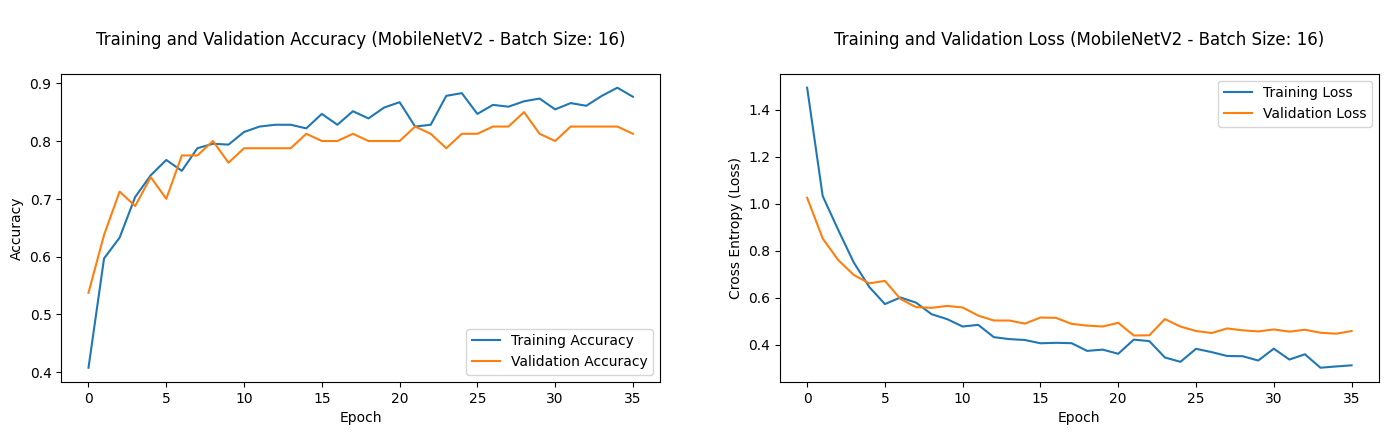

In [ ]:
# Menampilkan Grafik Akurasi dan Loss MobileNetV2
import matplotlib.pyplot as plt
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat dua grafik bersebelahan dalam satu gambar:
    1. Grafik Akurasi (Training vs Validasi)
    2. Grafik Loss (Training vs Validasi)
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Cross Entropy (Loss)')
    plt.xlabel('Epoch')

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

plot_history_side_by_side(history_mobilenet, "MobileNetV2", batch_size)


--- Menyiapkan Data Generator ---
Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.

--- Membangun Arsitektur MobileNetV2 ---
Arsitektur MobileNetV2 selesai dibangun.

--- Menyiapkan Callbacks ---
✅ Callbacks telah siap.

--- Mengompilasi Model MobileNetV2 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Memulai Pelatihan Model MobileNetV2 (Batch Size: 16, Epochs: 50) ---
INFO: Gambar akan di-resize menjadi 224x224 secara On-The-Fly selama pelatihan.
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2896 - loss: 1.8903
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - accuracy: 0.2904 - loss: 1.8867 - val_accuracy: 0.4875 - val_loss: 1.1995
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5248 - loss: 1.1211
Epoch 2: val_accuracy improved from 0.48750 to 0.61250, saving model to /content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_16/best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5248 - loss: 1.1210 - val_accuracy: 0.6125 - val_loss: 0.9753
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6550 - loss: 0.8363
Epoch 3: val_accuracy did not improve from 0.61250
40/40 ━━

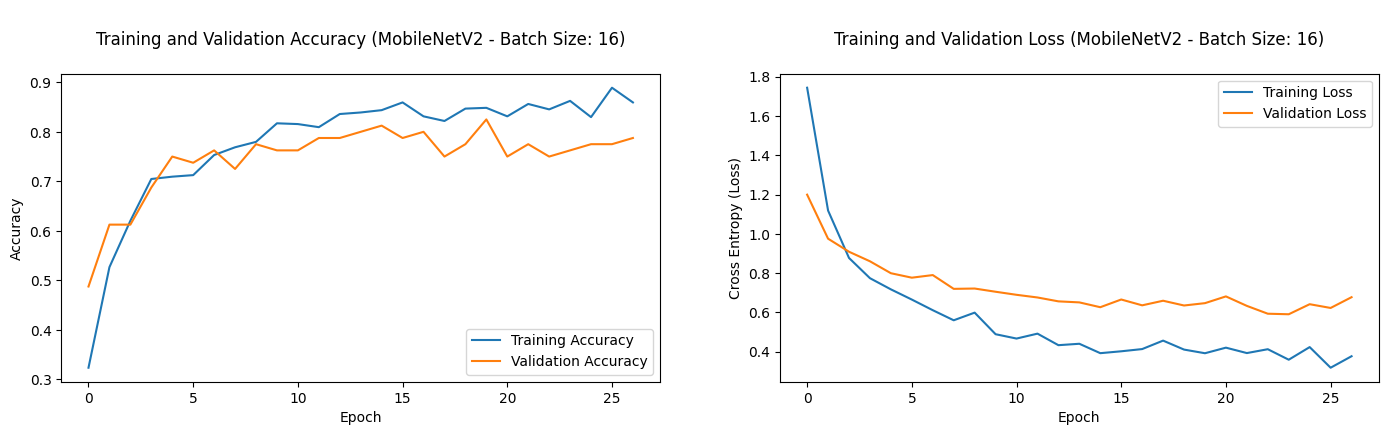

In [ ]:
#RESIZE ON TRAINING

# Menambahkan Random Seed
tf.random.set_seed(42)

# [DIUBAH] Pengaturan Location Path
# Arahkan ke folder dataset asli (resolusi penuh), bukan yang sudah di-resize
main_path = '/content/drive/MyDrive/Skripsi/Dataset/Dataset Fix/'
train_dir = os.path.join(main_path, 'Latih')
validation_dir = os.path.join(main_path, 'Validasi')

# Pengaturan parameter
target_size = (224, 224)
input_shape = (224, 224, 3)
target_class = 4
batch_size = 16
epochs = 50
histories_mobilenet = {}

# Menyiapkan Data Generator
print("\n--- Menyiapkan Data Generator ---")
# Augmentasi ini akan diterapkan pada gambar asli secara on-the-fly
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

# Untuk data validasi, kita hanya melakukan preprocessing tanpa augmentasi
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# `target_size` di sini akan me-resize gambar dari dataset asli secara on-the-fly
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=True, seed=42)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=target_size, class_mode='categorical',
    batch_size=batch_size, shuffle=False)

# Membangun Arsitektur Model
print("\n--- Membangun Arsitektur MobileNetV2 ---")
base_model_mobilenet = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False
model_mobilenet = tf.keras.Sequential([
    base_model_mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_class, activation='softmax')])
print("Arsitektur MobileNetV2 selesai dibangun.")

# Menyiapkan Callbacks
print("\n--- Menyiapkan Callbacks ---")

# [DIUBAH] Ubah lokasi penyimpanan model ke 'MobileNetV2 OTF' (On-The-Fly)
save_dir_mobilenet = f'/content/drive/MyDrive/Skripsi/Saved Models/MobileNetV2 OTF/bs_{batch_size}/'
os.makedirs(save_dir_mobilenet, exist_ok=True)
filepath_checkpoint = os.path.join(save_dir_mobilenet, "best_model.keras")
filepath_log = os.path.join(save_dir_mobilenet, "training_log.csv")

checkpoint_mobilenet = ModelCheckpoint(
    filepath=filepath_checkpoint,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

csv_logger_mobilenet = CSVLogger(filepath_log)

early_stopping_mobilenet = EarlyStopping(
    monitor='val_accuracy',
    patience=7, mode='max',
    verbose=1,
    restore_best_weights=True)

print("✅ Callbacks telah siap.")

# Periksa dan Compile Model Summary
print("\n--- Mengompilasi Model MobileNetV2 ---")
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

# Training Model Fit MobileNetV2
print(f"\n--- Memulai Pelatihan Model MobileNetV2 (Batch Size: {batch_size}, Epochs: {epochs}) ---")
print("INFO: Gambar akan di-resize menjadi 224x224 secara On-The-Fly selama pelatihan.")

start_time = time.time()
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_mobilenet, csv_logger_mobilenet, early_stopping_mobilenet])

print(f"\n\n Pelatihan MobileNetV2 Selesai!")
histories_mobilenet[f'bs{batch_size}_epochs{epochs}'] = history_mobilenet.history

# Menghitung Waktu dan Ukuran File
end_time = time.time()
total_time = end_time - start_time
num_actual_epochs = len(history_mobilenet.history['loss'])
avg_time_per_epoch = total_time / num_actual_epochs
best_val_acc = max(history_mobilenet.history['val_accuracy'])
epoch_best_val_acc = np.argmax(history_mobilenet.history['val_accuracy']) + 1
lowest_val_loss = min(history_mobilenet.history['val_loss'])
epoch_lowest_val_loss = np.argmin(history_mobilenet.history['val_loss']) + 1

print("\nRANGKUMAN PELATIHAN")
print("-" * 40)
print(f"Batch Size               : {batch_size}")
print(f"Optimizer                : Adam (LR: 0.001)")
print("-" * 40)
print(f"Val Accuracy Tertinggi   : {best_val_acc:.4f} (di Epoch ke-{epoch_best_val_acc})")
print(f"Val Loss Terendah        : {lowest_val_loss:.4f} (di Epoch ke-{epoch_lowest_val_loss})")
print(f"Total Waktu Pelatihan    : {int(total_time // 60)} menit {total_time % 60:.2f} detik")
print(f"Waktu per Epoch          : {avg_time_per_epoch:.2f} detik")


# Dapatkan ukuran file model terbaik
try:
    model_size_bytes = os.path.getsize(filepath_checkpoint)
    if model_size_bytes > (1024 * 1024):
        model_size = f"{model_size_bytes / (1024 * 1024):.2f} MB"
    else:
        model_size = f"{model_size_bytes / 1024:.2f} KB"
    print(f"Ukuran Model Terbaik     : {model_size}")
except FileNotFoundError:
    print(f"⚠️ File model terbaik tidak ditemukan di: {filepath_checkpoint}")


# Menampilkan Grafik Akurasi dan Loss MobileNetV2
import matplotlib.pyplot as plt
def plot_history_side_by_side(history, model_name, bs):
    """
    Fungsi untuk membuat dua grafik bersebelahan dalam satu gambar:
    1. Grafik Akurasi (Training vs Validasi)
    2. Grafik Loss (Training vs Validasi)
    """
    # Ekstrak data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(17, 4))

    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'\nTraining and Validation Accuracy ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'\nTraining and Validation Loss ({model_name} - Batch Size: {bs})\n')
    plt.ylabel('Cross Entropy (Loss)')
    plt.xlabel('Epoch')

    # Tampilkan kedua subplot dalam satu gambar
    plt.show()

plot_history_side_by_side(history_mobilenet, "MobileNetV2", batch_size)